# Diversity Indices
In this notebook we explore diversity at both the population and individual level. The primary metrics explored here are heterozygosity and fraction of runs of homozygosity (*F<sub>ROH</sub>*). ANGSD was used to estimate largely 'SNP'-based heterozygosity, while SMOOVE was used to call and genotype SVs (as outlined in [03_SV_discovery_and_Genotyping.md]), while [ROHAN](https://github.com/grenaud/rohan) was used to call runs of homozygosity (ROHs) and estimate *F<sub>ROH</sub>*. The python packages below were used to clean, format and visualise our data.  

In [34]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib.legend_handler import HandlerTuple
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.stats import linregress
from sklearn.metrics import r2_score
from scipy.stats import mannwhitneyu
from scipy import stats

path = '/nesi/nobackup/uc03718/'
os.chdir(path)
print(os.getcwd())

/nesi/nobackup/uc03718


## Individual observed heterozygosity (H<sub>O</sub>)
### Single Nucleotide Polymorphisms (SNPs)

### Structural Variant (SV) based estimates of heterozygosity

### Runs of Homozygosity 
 Following the recommendations, we removed all PCR-duplicates from BAM alignment files, estimated a transition/transversion ratio with [VCFtools](https://vcftools.github.io/index.html) v0.1.15, and defined an allowable level of heterozygosity within a 50kb window.  

In [ ]:
# Update with how I estimate base-pair frequency and use that instead of TSTV ratio to estimate ROH.

And the Ts/Tv ratio was estimated as a prior for ROHan with VCFtools using the BCF outputs from ANGSD.

This resulted in a TsTv ratio of 1.871 for tara iti, 2.507 for Australian fairy tern, and 2.725 for kakī.  

Finally, ROHan was run with the `--rohmu` flag varied to ensure regions containing ROHs were detected as per [this discussion](https://github.com/grenaud/ROHan/issues/12#issuecomment-1935539239). The value of 5 x 10<sup>-5</sup> and a window size of 50kb equates 2.5 heterozygous genotypes within this window. For kakī, this threshold was left at the default setting of 1 x 10<sup>-5</sup> and equated to 0.5 heterozygous sites within a 50kb window. This much lower ROH threshold for kakī is attributable to the much higher sequence depth for the kakī data (i.e, target 50x vs 10x sequence depth).  

We then prepared summary plots for ROHs, one file each for tara iti and Australian fairy tern containing all ROH sizes calculated using the mid. estimates of heterozygosity.  

We also parsed a file with subsetting the summary files of all individuals.  

We use the python packages below to visualise Inbreeding represented as *F<sub>ROH</sub>*. We leverage ROH position, size estimates, and the number of segments (i.e., sites) used to infer ROH topography as determined by [ROHan]() to represent individual inbreeding the tara iti, AFT and kakī populations. 

We also examined the proportion of the genome impacted by ROHs for each individual of Australian fairy tern and tara iti. The higher count of ROHs in tara iti population also translated to a higher proportion of the genome impacted overall. However, the vast majority of ROHs impacting the genome is attributable to those in the 'large' (>700kb in length) category. This indicates that the tara iti population has remained chronically small for several generations.  

In [31]:
roh = pd.read_csv('rohan/ROHs.tsv', sep='\t')
roh_segments = pd.read_csv('rohan/ROH_segment_summary.txt', sep='\t')
chroms = pd.read_csv('rohan/chroms.tsv', sep='\t')

roh = roh.merge(chroms[['Chromosome', 'Chromosome Size']], on='Chromosome', how='left')

roh_summary = roh[['Sample', 'Size Class', 'Population']]
roh_summary = roh_summary.groupby(['Sample', 'Size Class', 'Population']).size().reset_index(name='ROH Counts')
roh_summary = roh_summary.sort_values('Size Class', ascending=False)
roh_summary['ROH_POP'] = roh_summary['Population'] + '-' + roh_summary['Size Class']

roh_segments['Total Segments Included'] = roh_segments['Segments in ROH'] + roh_segments['Segments in non-ROH']

roh_len = roh[['Sample', 'ROH Length', 'Size Class', 'Population']]
roh_len = roh_len.groupby(['Sample', 'Size Class', 'Population'])['ROH Length'].sum().reset_index(name='ROH Total')


roh_len = roh_len.merge(roh_segments[['Sample', 'Total Segments Included']], on='Sample', how='left')

roh_len['Proportion'] = roh_len['ROH Total'] / roh_len['Total Segments Included']

roh_len = roh_len.sort_values('Size Class', ascending=False)
roh_len['ROH_POP'] = roh_len['Population'] + '-' + roh_len['Size Class']

Here we examined the ROH size distrobution. However, because medium and larger ROHs occur at a much lower frequency than small ROH, it is challenging to visualise the distribution. To help allevieate this, we log10 transformed ROH length prior to plotting.  

In [21]:
with pd.option_context('display.float_format', '{:.2f}'.format):
    print(roh[roh['Population']=='KI'].groupby(['Sample'])['ROH Length'].mean().reset_index())

    Sample  ROH Length
0   H01383   299416.14
1   H01384   201498.56
2   H01385   224429.22
3   H01386   299249.42
4   H01387   317782.78
5   H01388   201818.63
6   H01389   306413.30
7   H01390   355478.59
8   H01391   190322.58
9   H01392   246300.00
10  H01393   287449.74
11  H01394   277444.99
12  H01395   242526.92
13  H01396   198184.10
14  H01397   312377.53
15  H01398   268728.42
16  H01399   219059.66
17  H01400   312229.99
18  H01401   296103.15
19  H01402   239294.65
20  H01403   254476.89
21  H01404   317279.41
22  H01405   230450.00
23  H01406   237893.16


## Population Diversity
### Runs of Homozygosity (ROHs)
We first examined the number of short (>50kb & <=200kb in length), medium (>200kb & <=700kb in length) and long (>700kb in length) ROHs per individual. This is to provide some indication of long-, medium- and short-term inbreeding levels respectively for each of the populations. Here, we can see that tara iti consistently have more ROHs across all three size classes.  

In [27]:
def mann_whitney_test(df, group_col, value_col, group1, group2):
    group1_values = df[df[group_col] == group1][value_col]
    group2_values = df[df[group_col] == group2][value_col]
    stat, p_value = mannwhitneyu(group1_values, group2_values, alternative='two-sided')
    return stat, p_value

# Perform the test for indiv_total
groups = ['AU-Short ROH', 'AU-Medium ROH', 'AU-Long ROH', 'NZ-Short ROH', 'NZ-Medium ROH', 'NZ-Long ROH', 'KI_10x-Short ROH', 'KI_10x-Medium ROH', 'KI_10x-Long ROH', 'KI-Short ROH', 'KI-Medium ROH', 'KI-Long ROH']

results_total = {}

for i in range(len(groups)):
    for j in range(i + 1, len(groups)):
        group1 = groups[i]
        group2 = groups[j]
        stat, p_value = mann_whitney_test(roh_summary, 'ROH_POP', 'ROH Counts', group1, group2)
        results_total[f'{group1} vs {group2}'] = {'stat': stat, 'p_value': p_value}

# Print the results
print("Mann-Whitney U Test results for ROH counts:")
for comparison, result in results_total.items():
    print(f"{comparison}: U-statistic = {result['stat']}, p-value = {result['p_value']}")


Mann-Whitney U Test results for ROH counts:
AU-Short ROH vs AU-Medium ROH: U-statistic = 361.0, p-value = 1.4728853070303523e-07
AU-Short ROH vs AU-Long ROH: U-statistic = 361.0, p-value = 1.4207436261002553e-07
AU-Short ROH vs NZ-Short ROH: U-statistic = 25.0, p-value = 8.841092454074131e-10
AU-Short ROH vs NZ-Medium ROH: U-statistic = 644.0, p-value = 0.1008340744525664
AU-Short ROH vs NZ-Long ROH: U-statistic = 1026.0, p-value = 1.1526687331322753e-10
AU-Short ROH vs KI_10x-Short ROH: U-statistic = 0.0, p-value = 2.638044719210391e-08
AU-Short ROH vs KI_10x-Medium ROH: U-statistic = 1.0, p-value = 3.027031108147686e-08
AU-Short ROH vs KI_10x-Long ROH: U-statistic = 456.0, p-value = 2.628527657728747e-08
AU-Short ROH vs KI-Short ROH: U-statistic = 0.0, p-value = 2.638044719210391e-08
AU-Short ROH vs KI-Medium ROH: U-statistic = 39.0, p-value = 4.018168488469909e-06
AU-Short ROH vs KI-Long ROH: U-statistic = 456.0, p-value = 2.6316966627114692e-08
AU-Medium ROH vs AU-Long ROH: U-stati

In [26]:
roh_proportion = roh.groupby(['Sample', 'Population'])['ROH Length'].sum().reset_index(name='ROH Total')
indiv_roh_counts = roh.groupby(['Sample', 'Population'])['ROH Length'].count().reset_index(name='Count').sort_values('Count')
roh_segments = pd.read_csv('rohan/ROH_segment_summary.txt', sep='\t')
roh_segments['Total Segments Included'] = roh_segments['Segments in ROH'] + roh_segments['Segments in non-ROH']

roh_proportion = roh_proportion.merge(roh_segments[['Sample', 'Total Segments Included']], on='Sample', how='left')
roh_proportion['Froh'] = roh_proportion['ROH Total'] / roh_proportion['Total Segments Included']

roh_proportion.sort_values('Froh')

groups = ['AU', 'NZ', 'KI_10x', 'KI']

for i in range(len(groups)):
    standard_dev = roh_proportion[roh_proportion['Population']==groups[i]]['Froh'].std()
    count = roh_proportion[roh_proportion['Population']==groups[i]]['Froh'].count()
    standard_err = standard_dev / np.sqrt(count)
    print(f"Mean individual FROH for {groups[i]}: {roh_proportion[roh_proportion['Population']==groups[i]]['Froh'].mean()} +/- {standard_err}")


Mean individual FROH for AU: 0.07738820920883634 +/- 0.0025104285507874502
Mean individual FROH for NZ: 0.6610224900473282 +/- 0.005973950235148367
Mean individual FROH for KI_10x: 0.6140339468865548 +/- 0.008244778555971504
Mean individual FROH for KI: 0.5210378527522576 +/- 0.013412510655278822


In [6]:
groups = ['AU-Short ROH', 'AU-Medium ROH', 'AU-Long ROH', 'NZ-Short ROH', 'NZ-Medium ROH', 'NZ-Long ROH', 'KI_10x-Short ROH', 'KI_10x-Medium ROH', 'KI_10x-Long ROH', 'KI-Short ROH', 'KI-Medium ROH', 'KI-Long ROH']

results_total = {}

for i in range(len(groups)):
    for j in range(i + 1, len(groups)):
        group1 = groups[i]
        group2 = groups[j]
        stat, p_value = mann_whitney_test(roh_len, 'ROH_POP', 'Proportion', group1, group2)
        results_total[f'{group1} vs {group2}'] = {'stat': stat, 'p_value': p_value}

# Print the results
print("Mann-Whitney U Test results for FROH:")
for comparison, result in results_total.items():
    print(f"{comparison}: U-statistic = {result['stat']}, p-value = {result['p_value']}")

Mann-Whitney U Test results for FROH:
AU-Short ROH vs AU-Medium ROH: U-statistic = 322.0, p-value = 3.847371474424406e-05
AU-Short ROH vs AU-Long ROH: U-statistic = 341.0, p-value = 2.995041856121807e-06
AU-Short ROH vs NZ-Short ROH: U-statistic = 4.0, p-value = 1.6286077631013113e-10
AU-Short ROH vs NZ-Medium ROH: U-statistic = 0.0, p-value = 1.1705658783588675e-10
AU-Short ROH vs NZ-Long ROH: U-statistic = 0.0, p-value = 1.1705658783588675e-10
AU-Short ROH vs KI_10x-Short ROH: U-statistic = 0.0, p-value = 2.64122377673511e-08
AU-Short ROH vs KI_10x-Medium ROH: U-statistic = 0.0, p-value = 2.64122377673511e-08
AU-Short ROH vs KI_10x-Long ROH: U-statistic = 0.0, p-value = 2.64122377673511e-08
AU-Short ROH vs KI-Short ROH: U-statistic = 0.0, p-value = 2.64122377673511e-08
AU-Short ROH vs KI-Medium ROH: U-statistic = 0.0, p-value = 2.64122377673511e-08
AU-Short ROH vs KI-Long ROH: U-statistic = 0.0, p-value = 2.64122377673511e-08
AU-Medium ROH vs AU-Long ROH: U-statistic = 327.0, p-value

In [32]:
print(roh_proportion[roh_proportion['Population']=='NZ'].sort_values(by='Froh', ascending=True))

    Sample Population  ROH Total  Total Segments Included      Froh
75    TI21         NZ  513850000               1024550000  0.501537
69   SND11         NZ  589450000               1047750000  0.562586
68   SND06         NZ  610650000               1059850000  0.576166
67   SND04         NZ  617750000               1059100000  0.583278
91    TI65         NZ  641150000               1071550000  0.598339
80    TI40         NZ  648400000               1069550000  0.606236
76    TI35         NZ  657300000               1081850000  0.607570
103   TI82         NZ  678450000               1086850000  0.624235
104   TI83         NZ  671350000               1074750000  0.624657
71    SP03         NZ  674900000               1078350000  0.625864
119   TI98         NZ  690500000               1090850000  0.632993
105   TI84         NZ  683850000               1076950000  0.634988
101   TI78         NZ  692950000               1089200000  0.636201
96    TI70         NZ  697850000               1

The individuals with the smallest, median, and largest *F<sub>ROH</sub>* for each group.  
- Australian fairy tern
    - Smallest *F<sub>ROH</sub>*: AU13 (6.077%)
    - Median *F<sub>ROH</sub>*: AU06 (7.2622%)
    - Largest *F<sub>ROH</sub>*: AU03 (10.4434%)
- Tara iti
    - Smallest *F<sub>ROH</sub>*: TI21 (50.1537%)
    - Median *F<sub>ROH</sub>*: TI54 (66.241%)
    - Largest *F<sub>ROH</sub>*: TI92 (72.5391%)
- Kakī low-coverage
    - Smallest *F<sub>ROH</sub>*: H01396 (55.1038%)
    - Median *F<sub>ROH</sub>*: H01389 (62.8498%)
    - Largest *F<sub>ROH</sub>*: H01387 (69.1370%)
- Kakī high-coverage
    - Smallest *F<sub>ROH</sub>*: H01396 (37.0804%)
    - Median *F<sub>ROH</sub>*: H01397 (53.6666%)
    - Largest *F<sub>ROH</sub>*: H01387 (61.6754%)

- OLD Kakī low-coverage
    - Smallest *F<sub>ROH</sub>*: H01402 (24.625%)
    - Median *F<sub>ROH</sub>*: H01406 (36.51%)
    - Largest *F<sub>ROH</sub>*: H01387 (49.57%)
- OLD Kakī high-coverage
    - Smallest *F<sub>ROH</sub>*: H01396 (17.816%)
    - Median *F<sub>ROH</sub>*: H01406 (31.092%)
    - Largest *F<sub>ROH</sub>*: H01390 (38.175%)

In [47]:
def plot_roh_multi_samples(samples, roh_df, bin_size=10_000, figsize=(20, 6), show_legend=False):
    """
    Plot ROH regions for multiple samples in vertically arranged subplots.
    Colors are based on ROH Class instead of overlap heatmap.
    
    Parameters:
    samples: list of 3 sample names
    roh_df: DataFrame containing ROH data with columns including 'Sample', 'Chromosome', 'Start', 'End', 'ROH Class'
    bin_size: bin size for plotting (default 10,000)
    figsize: figure size tuple
    show_legend: boolean to control legend display (default True)
    """
    
    if len(samples) != 3:
        raise ValueError("Exactly 3 samples must be provided")
    
    # Define color map for ROH Classes
    # You can customize these colors based on your ROH classes
    size_class_colors = {
        'Short ROH': 'seagreen',     # Red
        'Medium ROH': 'wheat',    # Teal  
        'Long ROH': 'coral',      # Blue
        # Add more classes as needed
    }
    
     # Get chromosome information from first sample
    sample_data = roh_df[roh_df['Sample'] == samples[0]]
    if sample_data.empty:
        raise ValueError(f"No data found for sample {samples[0]}")
    
    # Get all chromosomes and their sizes from the ROH data
    all_samples_data = roh_df[roh_df['Sample'].isin(samples)]
    
    # Use the 'Chromosome Size' column from the dataframe
    chrom_info = all_samples_data[['Chromosome', 'Chromosome Size']].drop_duplicates()
    chrom_sizes = dict(zip(chrom_info['Chromosome'], chrom_info['Chromosome Size']))
    
    # Sort chromosomes (customize this order as needed)
    chrom_order = sorted(chrom_sizes.keys(), key=lambda x: chrom_sizes[x], reverse=True)
    
    # Create figure with 3 vertically stacked subplots
    fig, axes = plt.subplots(3, 1, figsize=figsize, sharex=True)
    
    # Calculate cumulative positions for chromosomes
    cumulative_pos = 0
    chrom_positions = {}
    chrom_boundaries = []
    
    for chrom in chrom_order:
        chrom_positions[chrom] = cumulative_pos
        cumulative_pos += chrom_sizes[chrom]
        chrom_boundaries.append(cumulative_pos)
    
    total_genome_size = cumulative_pos
    
    # Plot each sample
    for idx, sample in enumerate(samples):
        ax = axes[idx]
        sample_roh = roh_df[roh_df['Sample'] == sample]
        
        if sample_roh.empty:
            print(f"Warning: No ROH data found for sample {sample}")
            ax.text(0.5, 0.5, f'No data for {sample}', transform=ax.transAxes, 
                   ha='center', va='center', fontsize=12)
            ax.set_ylabel(sample, rotation=0, ha='right', va='center')
            continue
        
        # Get unique Size classes for this sample
        size_classes = sample_roh['Size Class'].unique()
        
        # Plot ROH regions for each class
        for size_class in size_classes:
            class_data = sample_roh[sample_roh['Size Class'] == size_class]
            color = size_class_colors.get(size_class, '#808080')  # Default gray if class not found
            
            for _, roh in class_data.iterrows():
                chrom = roh['Chromosome']
                if chrom in chrom_positions:
                    start_pos = chrom_positions[chrom] + roh['Start']
                    end_pos = chrom_positions[chrom] + roh['End']
                    width = end_pos - start_pos
                    
                    # Create rectangle for ROH region
                    rect = patches.Rectangle((start_pos, 0), width, 1, 
                                           facecolor=color, edgecolor='none', alpha=0.8)
                    ax.add_patch(rect)
        
        # Customize subplot
        #ax.set_ylabel(sample, rotation=0, ha='right', va='center', fontsize=12)
        ax.set_ylim(0, 1)
        ax.set_xlim(0, total_genome_size)
        
        # Add chromosome boundaries with black dashed lines
        for boundary in chrom_boundaries[:-1]:  # Skip the last boundary
            ax.axvline(x=boundary, color='black', linestyle='--', alpha=0.7, linewidth=2)
        
        # Remove y-ticks
        ax.set_xticks([])
        ax.set_yticks([])
        
        # Only show x-axis labels on bottom plot
        #if idx < 2:
        #    ax.set_xticks([])
    
    # Add chromosome labels on bottom plot
    #bottom_ax = axes[2]
    chrom_centers = []
    chrom_labels = []
    
    for chrom in chrom_order:
        center = chrom_positions[chrom] + chrom_sizes[chrom] / 2
        chrom_centers.append(center)
        chrom_labels.append(str(chrom))
    
    #bottom_ax.set_xticks(chrom_centers)
    #bottom_ax.set_xticklabels(chrom_labels, rotation=45, ha='right')
    #bottom_ax.set_xlabel('Chromosome', fontsize=12)
    
    # Create legend for Size classes (only if show_legend is True)
    if show_legend:
        legend_elements = []
        for size_class, color in size_class_colors.items():
            # Only include classes that appear in the data
            if any(size_class in roh_df[roh_df['Sample'] == sample]['Size Class'].values for sample in samples):
                legend_elements.append(patches.Patch(color=color, label=size_class))
        
        if legend_elements:
            fig.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(0.98, 0.95))
    
    plt.tight_layout()
    return fig, axes

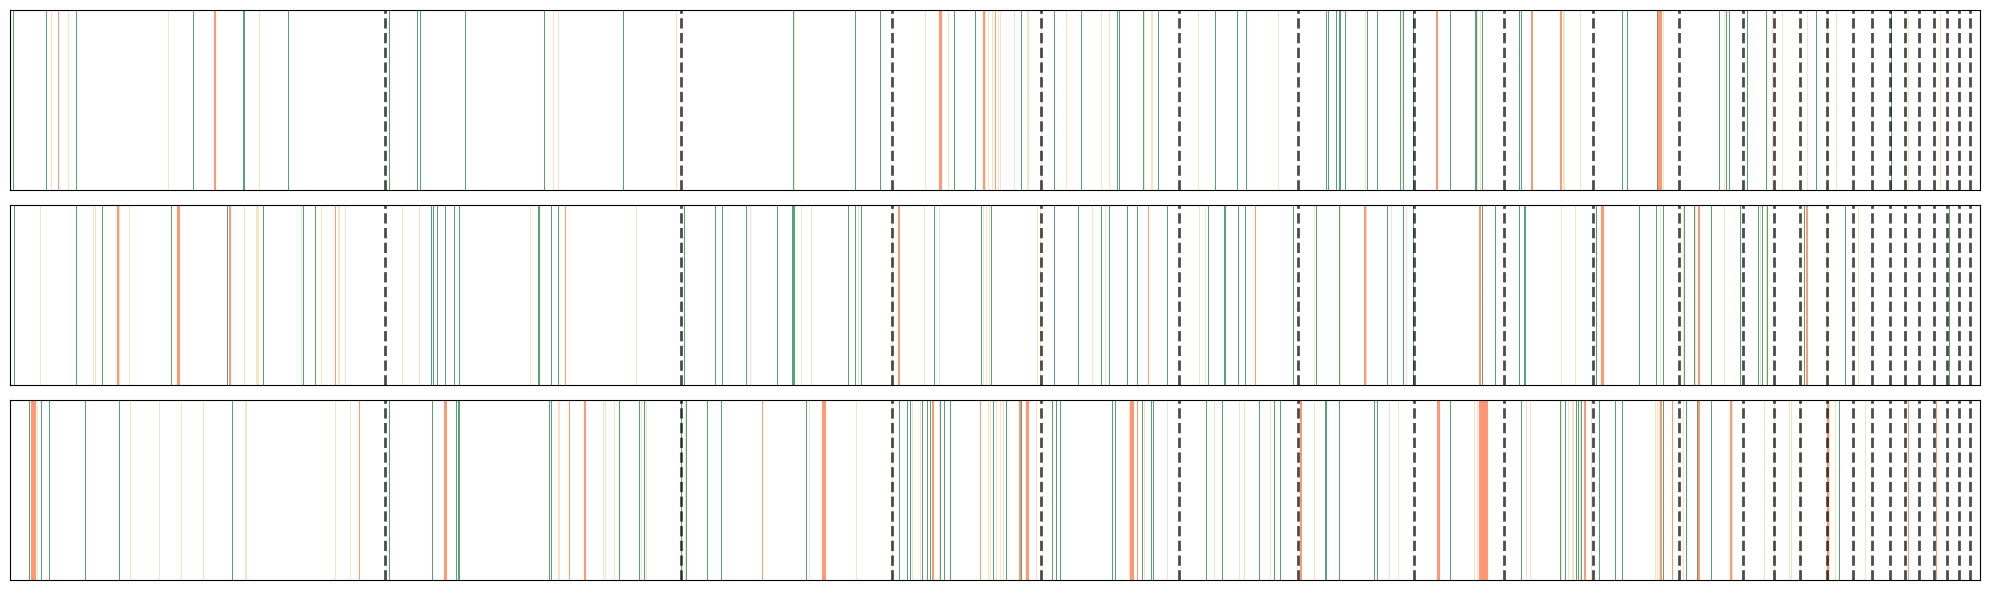

In [52]:
# Usage example:
# Define your 3 samples
samples_to_plot = ['AU13', 'AU06', 'AU03']  # Replace with your actual sample names

# Create the multi-sample plot
fig, axes = plot_roh_multi_samples(samples_to_plot, roh)

plt.savefig('TI_ms_plots/AU_indiv_roh.png', dpi=300, bbox_inches='tight')

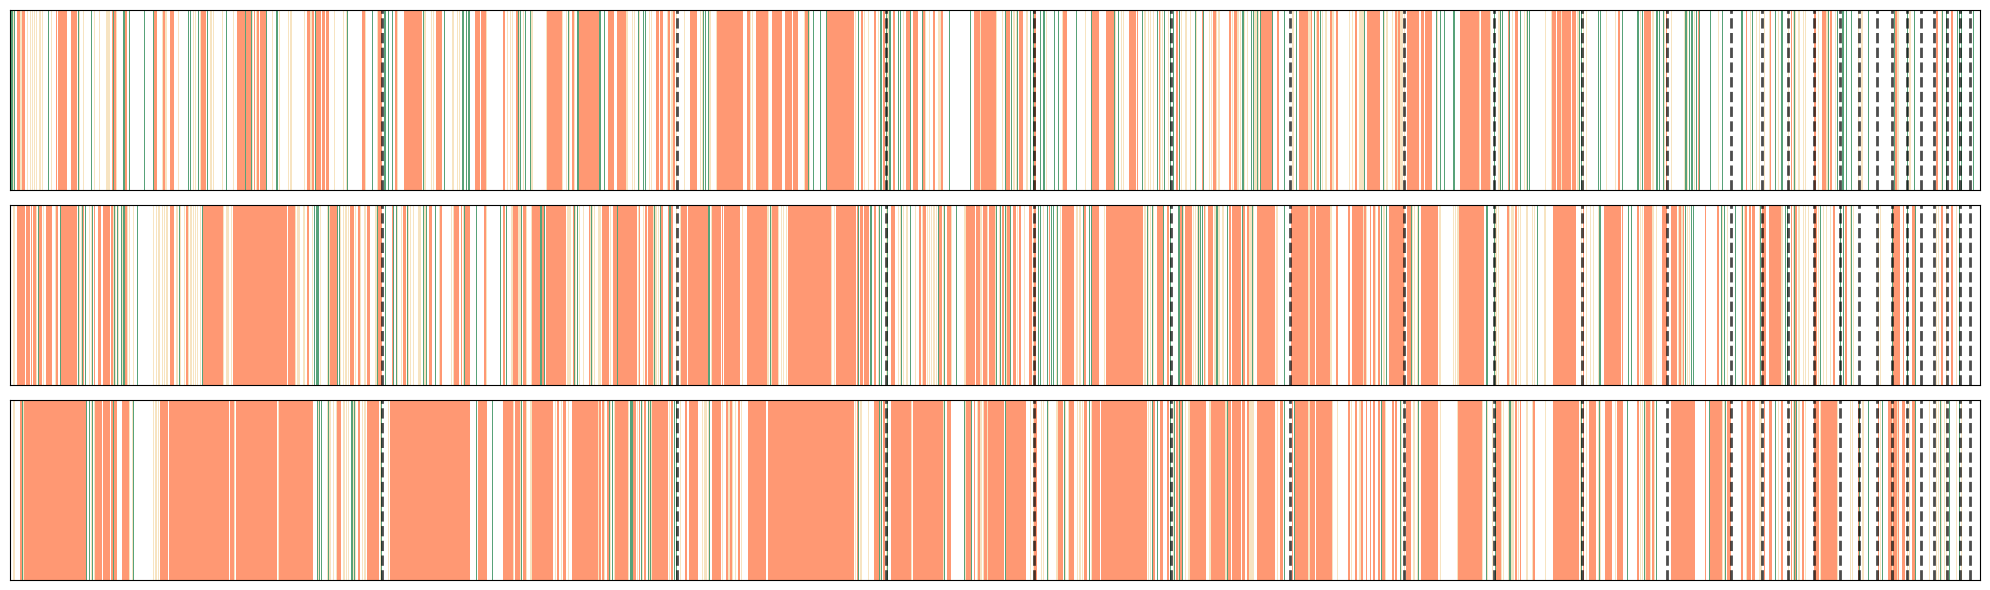

<Figure size 640x480 with 0 Axes>

In [56]:
# Usage example:
# Define your 3 samples
samples_to_plot = ['TI21', 'TI54', 'TI92']  # Replace with your actual sample names

# Create the multi-sample plot
fig, axes = plot_roh_multi_samples(samples_to_plot, roh)
plt.show()

plt.savefig('TI_ms_plots/NZ_indiv_roh.png', dpi=300, bbox_inches='tight')

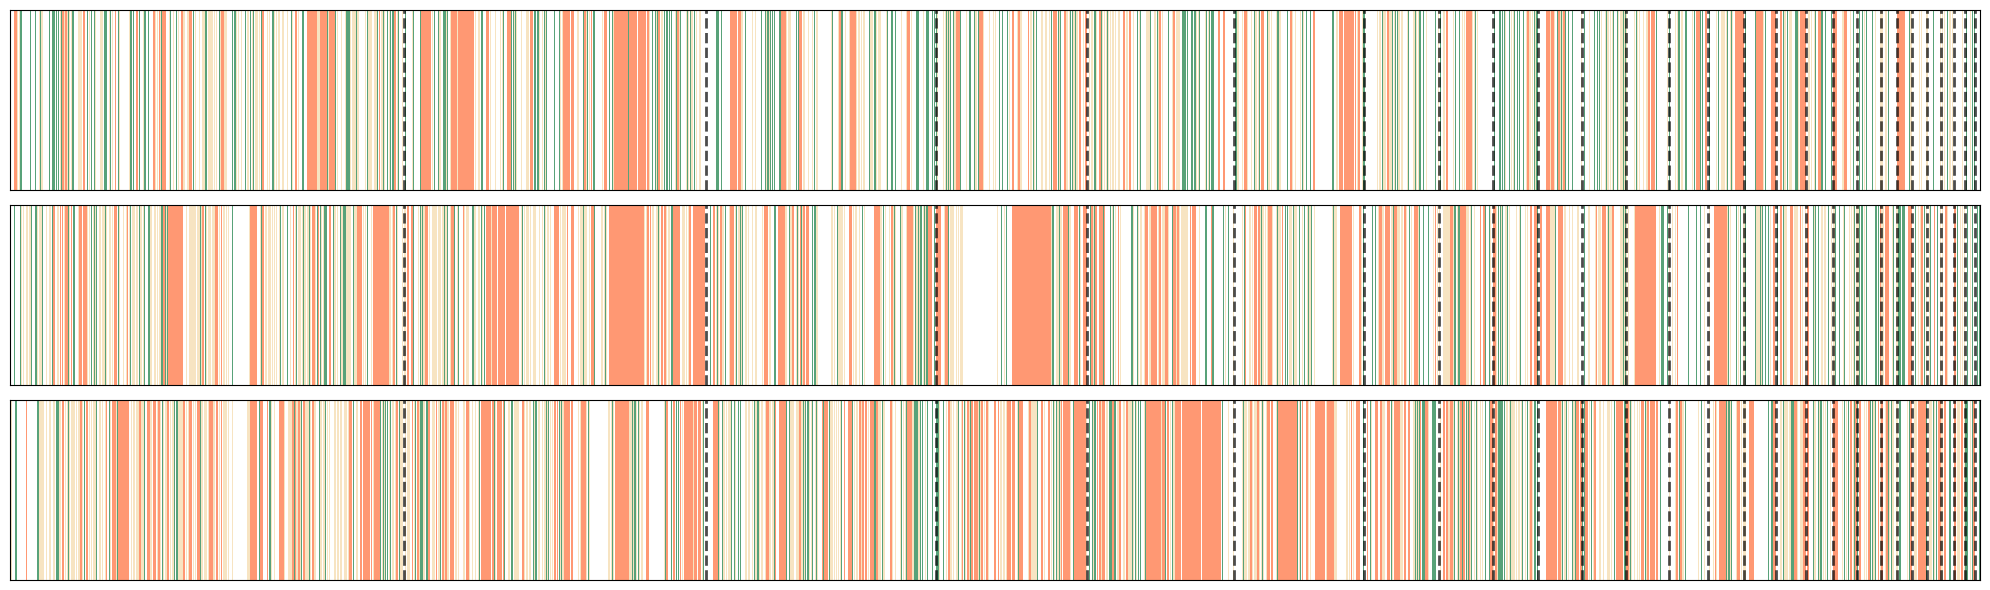

<Figure size 640x480 with 0 Axes>

In [54]:
# Usage example:
# Define your 3 samples
samples_to_plot = ['H01396_10x', 'H01389_10x', 'H01387_10x']  # Replace with your actual sample names

# Create the multi-sample plot
fig, axes = plot_roh_multi_samples(samples_to_plot, roh)
plt.show()

plt.savefig('TI_ms_plots/KI_10x_indiv_roh.png', dpi=300, bbox_inches='tight')

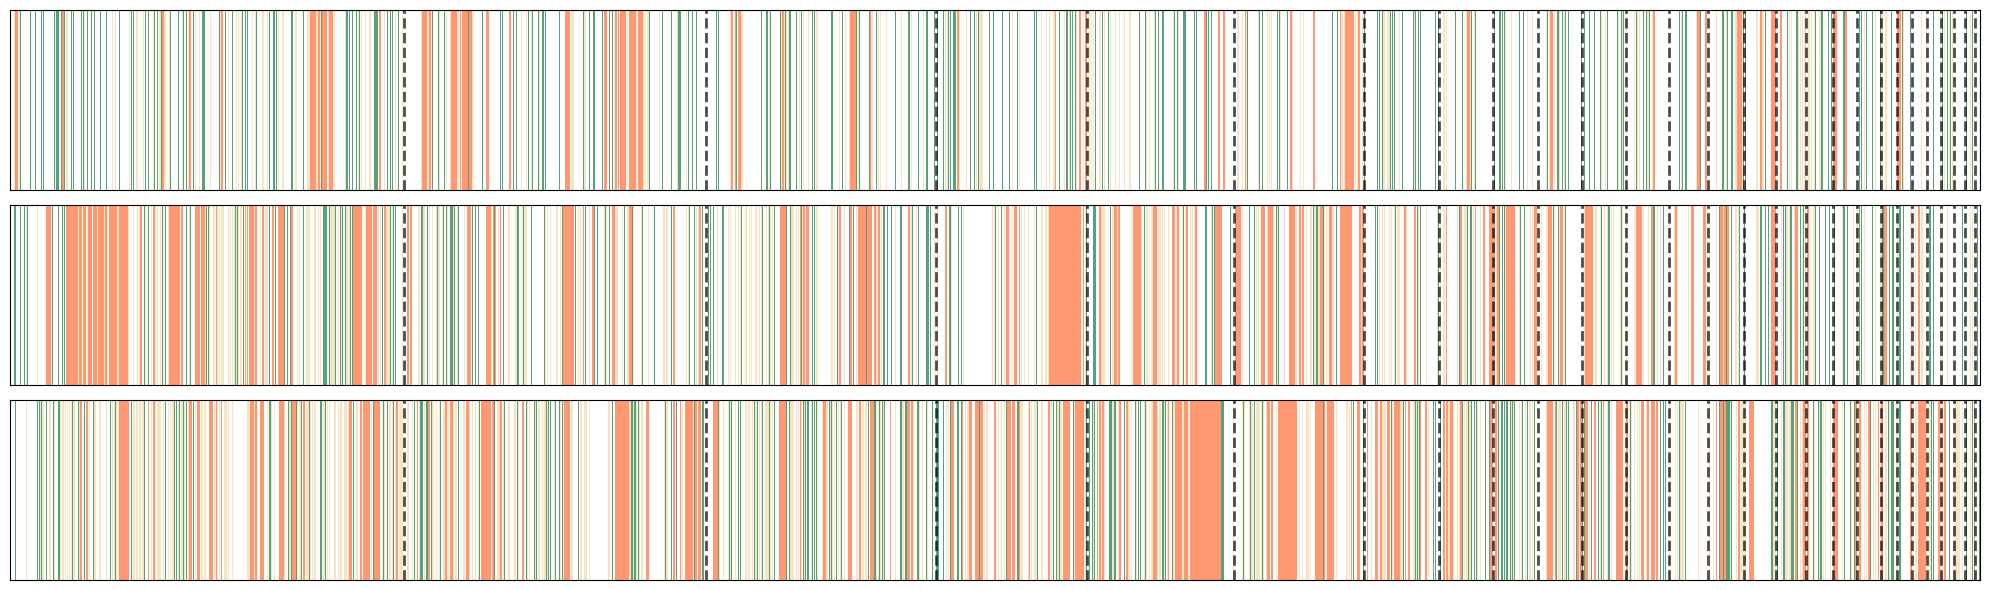

In [55]:
# Usage example:
# Define your 3 samples
samples_to_plot = ['H01396', 'H01397', 'H01387']  # Replace with your actual sample names

# Create the multi-sample plot
fig, axes = plot_roh_multi_samples(samples_to_plot, roh)

plt.savefig('TI_ms_plots/KI_indiv_roh.png', dpi=300, bbox_inches='tight')

We then examined the density of Runs of Homozygosity (ROHs) by size class. Here, we plot ROHs presence at a particular location across individuals for chromosome 1 as a means to visualise relative *fROH* among individuals.  

To start, we load and subset the original `ROH_density.tsv` file by population, ROH size class, and position (`BEGIN` and `END`).  

We then define a plot function that marks the presence/absence of ROHs by their `BEGIN` and `END` position along chromosome 1. The color `seagreen` denotes ROHs smaller than or equal to 200kb in length, `wheat` indicates ROHs larger than 200kb and smaller than or equal to 700kb, and `coral` represents ROHs larger than 700kb.  

In [4]:
def plot_rohs(df, chromosome, individuals, populations, continuous_range, alpha_multiplier=1, color_mapping=None, figsize=(20, 15)):
    """
    Plot ROH presence along the chromosome for specific individuals.

    Parameters:
        df (DataFrame): Input DataFrame containing 'Chromosome', 'BEGIN', 'END', 'Size Class', 'Sample', and 'Population' columns.
        chromosome (str): Chromosome to plot.
        individuals (list): List of individuals to include in the plot.
        populations (list): List of populations corresponding to the individuals.
        continuous_range (range or list): Continuous range of positions to consider.
        alpha_multiplier (float): Multiplier to adjust alpha based on the number of overlapping ranges.
        color_mapping (dict): Mapping of ROH classes to colors.
        figsize (tuple, optional): Size of the figure in inches (width, height).

    Returns:
        None
    """
    num_individuals = len(individuals)
    fig, axs = plt.subplots(num_individuals, 1, figsize=figsize, sharex=True, sharey=True)

    for i, (individual, population) in enumerate(zip(individuals, populations)):
        ax = axs[i]
        # Filter Pandas DataFrame for the specified chromosome and individual
        chrom_ind_df = df[(df['Chromosome'] == chromosome) & (df['IDs'] == individual)]
        
        # Get color for ROH class
        if color_mapping:
            chrom_ind_df['Color'] = chrom_ind_df['Size Class'].map(color_mapping)
        else:
            chrom_ind_df['Color'] = 'steelblue'  # Default color

        # Plot ROH presence
        for _, row in chrom_ind_df.iterrows():
            start, end = row['BEGIN'], row['END']
            ax.fill_between(range(start, end+1), 0, 1, color=row['Color'], alpha=alpha_multiplier, edgecolor=None)
        
        # Set y-axis label to population
        ax.set_ylabel(population, labelpad=5, fontsize=18)

        # Remove y-axis ticks
        ax.set_xticks([])
        ax.set_yticks([])

        # Set x-axis limits
        ax.set_xlim(min(continuous_range), max(continuous_range))
        ax.set_ylim(0, 1)

    axs[-1].set_xlabel('Position on Chromosome 1', fontsize=25)
    axs[0].set_title('E)', loc='left', fontsize=35)
    plt.tight_layout()

# Define Color mapping
color_mapping = {
    'Short ROH': 'seagreen',
    'Medium ROH': 'wheat',
    'Long ROH': 'coral'
}
# Define chromosome size
chr1_size = range(0, 219000000, 1000)

In [15]:
roh = pd.read_csv('rohan/ROHs.tsv', sep='\t')
chr = pd.read_csv('rohan/chroms.tsv', sep='\t')
roh_segments = pd.read_csv('rohan/ROH_segment_summary.txt', sep='\t')

roh_segments['Total Segments Included'] = roh_segments['Segments in ROH'] + roh_segments['Segments in non-ROH']

roh = roh.merge(chr[['Chromosome', 'Chromosome Size']], on='Chromosome', how='left')
roh = roh.merge(roh_segments[['Sample', 'Total Segments Included']], on='Sample', how='left')
roh.tail()

,Sample,Chromosome,Start,End,ROH Length,Size Class,Population,Chromosome Size,Total Segments Included
152856,H01406_10x,scaffold_27,3500001,3550000,50000,Short ROH,KI_10x,5642978,922500000
152857,H01406_10x,scaffold_27,4500001,4600000,100000,Short ROH,KI_10x,5642978,922500000
152858,H01406_10x,scaffold_27,4800001,5300000,500000,Medium ROH,KI_10x,5642978,922500000
152859,H01406_10x,scaffold_28,750001,800000,50000,Short ROH,KI_10x,2693935,922500000
152860,H01406_10x,scaffold_28,2200001,2350000,150000,Short ROH,KI_10x,2693935,922500000


In [16]:
def compute_roh_bin_counts(df, bin_size=10_000):
    """
    Count ROH overlaps in fixed bins across all chromosomes.

    Parameters:
        df (pd.DataFrame): Input DataFrame with columns:
                           ['Chromosome', 'Start', 'End', 'Chromosome Size']
        bin_size (int): Bin size in base pairs (default: 10,000 bp)

    Returns:
        heatmap_df (pd.DataFrame): Long-format bin-level ROH counts
        chrom_sizes (pd.DataFrame): Chromosome sizes and cumulative starts
        chrom_order (list): Chromosomes ordered by size (descending)
    """
    df = df.copy()  # ✅ prevent SettingWithCopyWarning
    df['Chromosome Size'] = pd.to_numeric(df['Chromosome Size'], errors='coerce')
    
    chrom_sizes = df[['Chromosome', 'Chromosome Size']].drop_duplicates()
    chrom_order = chrom_sizes.sort_values('Chromosome Size', ascending=False)['Chromosome'].tolist()
    
    bin_counts = []

    for chrom in chrom_order:
        chrom_df = df[df['Chromosome'] == chrom]
        chrom_len = chrom_df['Chromosome Size'].iloc[0]
        num_bins = int(np.ceil(chrom_len / bin_size))
        bins = np.zeros(num_bins, dtype=int)

        for _, row in chrom_df.iterrows():
            start_bin = int(row['Start'] // bin_size)
            end_bin = int(row['End'] // bin_size)
            bins[start_bin:end_bin + 1] += 1

        bin_counts.extend([
            {'Chromosome': chrom, 'Bin': i, 'ROH Count': count}
            for i, count in enumerate(bins)
        ])

    heatmap_df = pd.DataFrame(bin_counts)
    return heatmap_df, chrom_sizes, chrom_order

In [17]:
def plot_roh_horizontal_bar(heatmap_df, chrom_sizes, bin_size=10_000, vmax=2):
    """
    Plot ROH overlap density as a horizontal color bar across all chromosomes.

    Parameters:
        heatmap_df (pd.DataFrame): Output from compute_roh_bin_counts
        chrom_sizes (pd.DataFrame): Chromosome sizes
        bin_size (int): Bin size used in computationax.axvline(row['Cumulative Start'], color='black', linestyle='-', linewidth=2)
        vmax (int): Maximum value for color scale
    """
    # Compute cumulative start positions
    chrom_sizes = chrom_sizes.sort_values('Chromosome Size', ascending=False)
    chrom_sizes['Cumulative Start'] = chrom_sizes['Chromosome Size'].cumsum() - chrom_sizes['Chromosome Size']
    
    # Merge into bin dataframe and compute global position
    heatmap_df = heatmap_df.merge(chrom_sizes[['Chromosome', 'Cumulative Start']], on='Chromosome', how='left')
    heatmap_df['Global Position'] = heatmap_df['Cumulative Start'] + heatmap_df['Bin'] * bin_size + (bin_size // 2)
    
    # Sort by genome-wide position
    heatmap_df = heatmap_df.sort_values('Global Position')
    values = heatmap_df['ROH Count'].values
    norm = plt.Normalize(vmin=0, vmax=vmax)
    colors = plt.cm.BuPu(norm(values))

    # Plot
    fig, ax = plt.subplots(figsize=(20, 2))
    ax.imshow([colors], aspect='auto', extent=[0, heatmap_df['Global Position'].max(), 0, 1])

    # Draw chromosome boundaries
    for _, row in chrom_sizes.iterrows():
        ax.axvline(row['Cumulative Start'], color='black', linestyle='--', linewidth=1.5)

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim([0, heatmap_df['Global Position'].max()])
    ax.set_title("Whole-genome ROH Overlap Density ({} bp bins)".format(bin_size))

    # Colorbar
    sm = plt.cm.ScalarMappable(cmap='BuPu', norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, orientation='horizontal', pad=0.2)
    cbar.set_label("ROH Count")

    plt.tight_layout()
    plt.show()

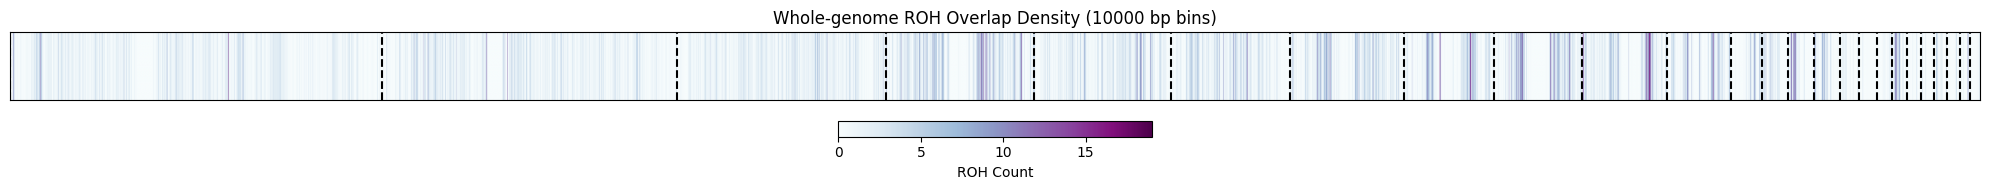

In [ ]:
AU = roh[roh['Population']=='AU']

heatmap_df, chrom_sizes, chrom_order = compute_roh_bin_counts(AU, bin_size=10_000)

plot_roh_horizontal_bar(heatmap_df, chrom_sizes, bin_size=10_000, vmax=19)

plt.savefig('TI_ms_plots/AU_whole-genome_overlaps.png', dpi=300, bbox_inches='tight')

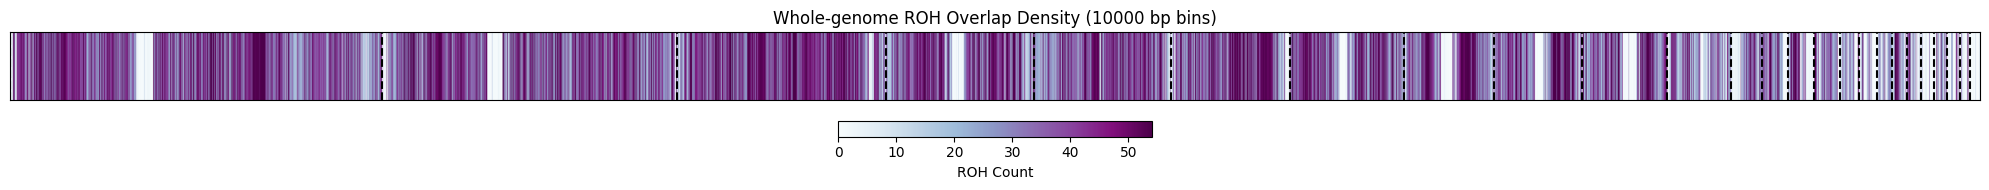

In [ ]:
TI = roh[roh['Population']=='NZ']
heatmap_df, chrom_sizes, chrom_order = compute_roh_bin_counts(TI, bin_size=10_000)

plot_roh_horizontal_bar(heatmap_df, chrom_sizes, bin_size=10_000, vmax=54)

plt.savefig('TI_ms_plots/NZ_whole-genome_overlaps.png', dpi=300, bbox_inches='tight')

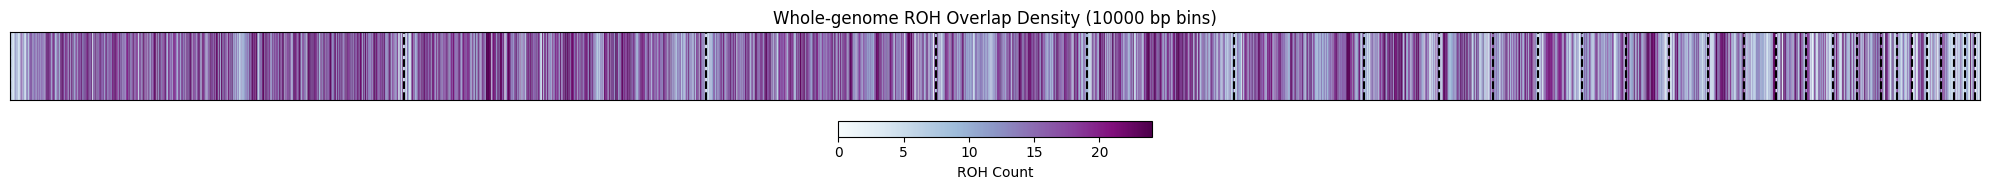

In [ ]:
KI_10x = roh[roh['Population']=='KI_10x']
heatmap_df, chrom_sizes, chrom_order = compute_roh_bin_counts(KI_10x, bin_size=10_000)

plot_roh_horizontal_bar(heatmap_df, chrom_sizes, bin_size=10_000, vmax=24)

plt.savefig('TI_ms_plots/KI_10x_whole-genome_overlaps.png', dpi=300, bbox_inches='tight')

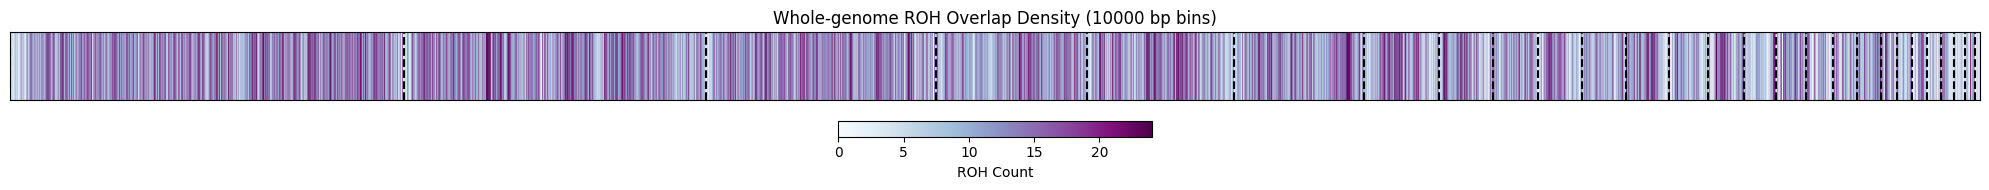

In [ ]:
KI = roh[roh['Population']=='KI']
heatmap_df, chrom_sizes, chrom_order = compute_roh_bin_counts(KI, bin_size=10_000)

plot_roh_horizontal_bar(heatmap_df, chrom_sizes, bin_size=10_000, vmax=24)

plt.savefig('TI_ms_plots/KI_whole-genome_overlaps.png', dpi=300, bbox_inches='tight')

Samples with lowest, median, and highest Froh

The individuals with the smallest, median, and largest *F<sub>ROH</sub>* for each group.  
- Australian fairy tern
    - Smallest *F<sub>ROH</sub>*: AU13 (6.077%)
    - Median *F<sub>ROH</sub>*: AU06 (7.2622%)
    - Largest *F<sub>ROH</sub>*: AU03 (10.4434%)
- Tara iti
    - Smallest *F<sub>ROH</sub>*: TI21 (50.1537%)
    - Median *F<sub>ROH</sub>*: TI54 (66.241%)
    - Largest *F<sub>ROH</sub>*: TI92 (72.5391%)
- Kakī low-coverage
    - Smallest *F<sub>ROH</sub>*: H01402 (24.625%)
    - Median *F<sub>ROH</sub>*: H01406 (36.51%)
    - Largest *F<sub>ROH</sub>*: H01387 (49.57%)
- Kakī high-coverage
    - Smallest *F<sub>ROH</sub>*: H01396 (17.816%)
    - Median *F<sub>ROH</sub>*: H01406 (31.092%)
    - Largest *F<sub>ROH</sub>*: H01390 (38.175%)

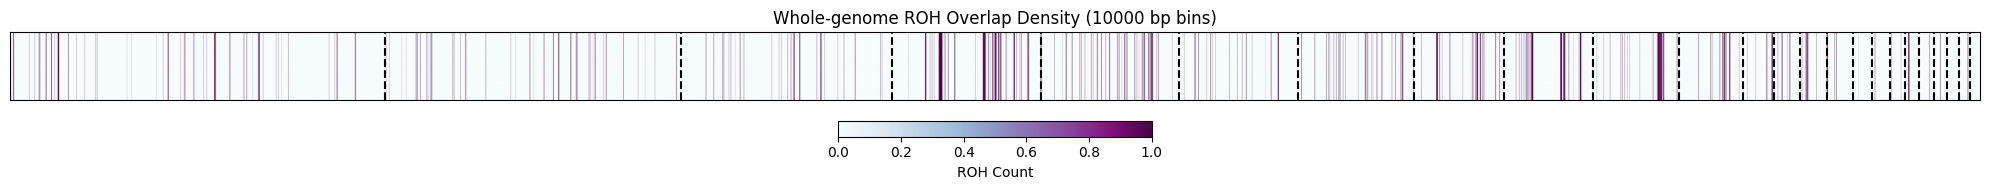

In [21]:
heatmap_df, chrom_sizes, chrom_order = compute_roh_bin_counts(roh[roh['Sample']=='AU13'], bin_size=10_000)

plot_roh_horizontal_bar(heatmap_df, chrom_sizes, bin_size=10_000, vmax=1)

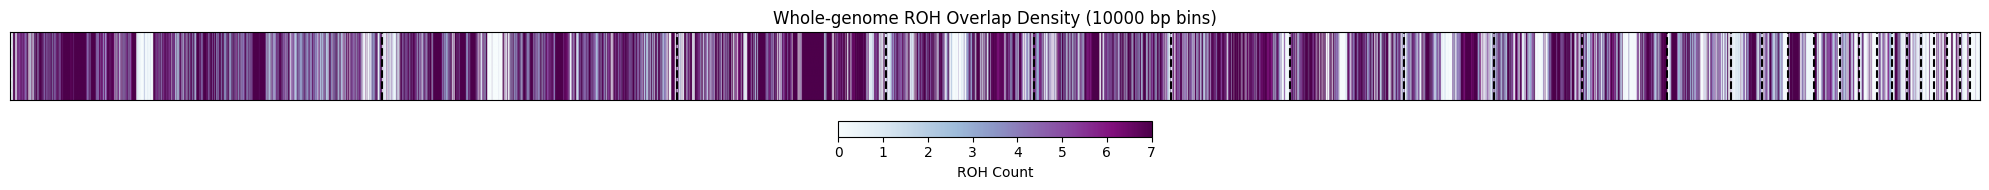

In [18]:
# Group 1
group1_samples = ['TI62', 'TI65', 'TI82', 'TI83', 'TI84', 'TI90', 'TI98', 'TI101']

G1 = TI[TI['Sample'].isin(group1_samples)]

heatmap_df, chrom_sizes, chrom_order = compute_roh_bin_counts(G1, bin_size=10_000)

plot_roh_horizontal_bar(heatmap_df, chrom_sizes, bin_size=10_000, vmax=7)

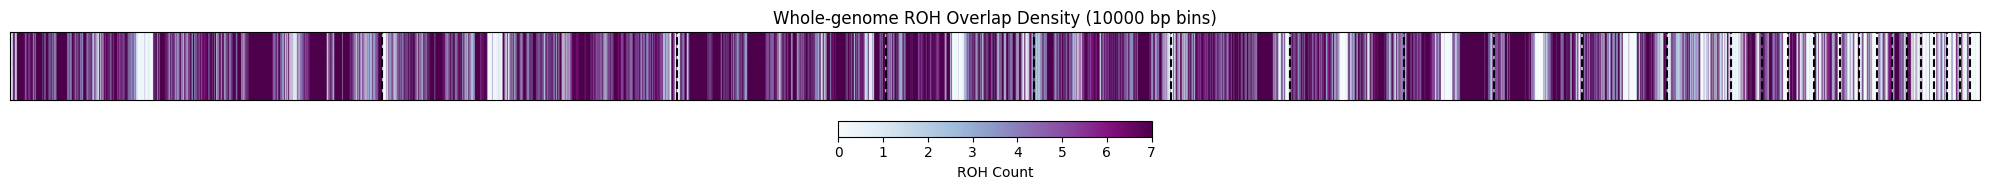

In [19]:
# Group 2
group2_samples = ['TI21', 'TI64', 'TI66', 'TI86', 'TI87', 'TI95', 'TI97', 'TI100']

G2 = TI[TI['Sample'].isin(group2_samples)]

heatmap_df, chrom_sizes, chrom_order = compute_roh_bin_counts(G2, bin_size=10_000)

plot_roh_horizontal_bar(heatmap_df, chrom_sizes, bin_size=10_000, vmax=7)

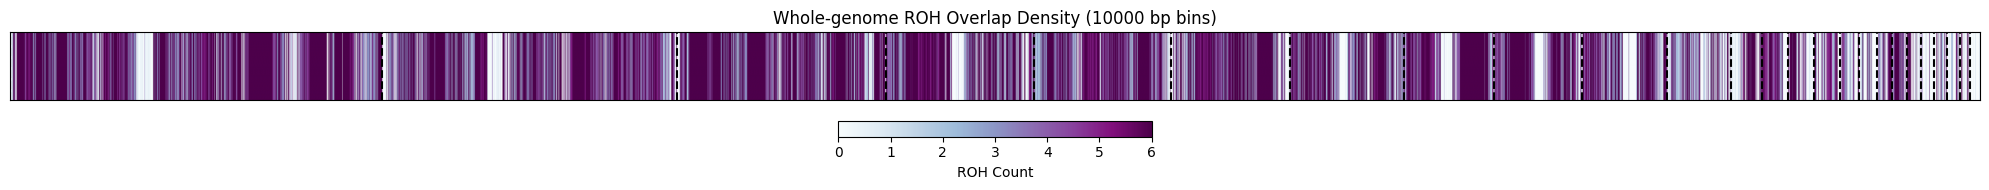

In [20]:
# Group 2 without TI21
G2_noTI21 = G2[G2['Sample']!='TI21']

heatmap_df, chrom_sizes, chrom_order = compute_roh_bin_counts(G2_noTI21, bin_size=10_000)

plot_roh_horizontal_bar(heatmap_df, chrom_sizes, bin_size=10_000, vmax=6)

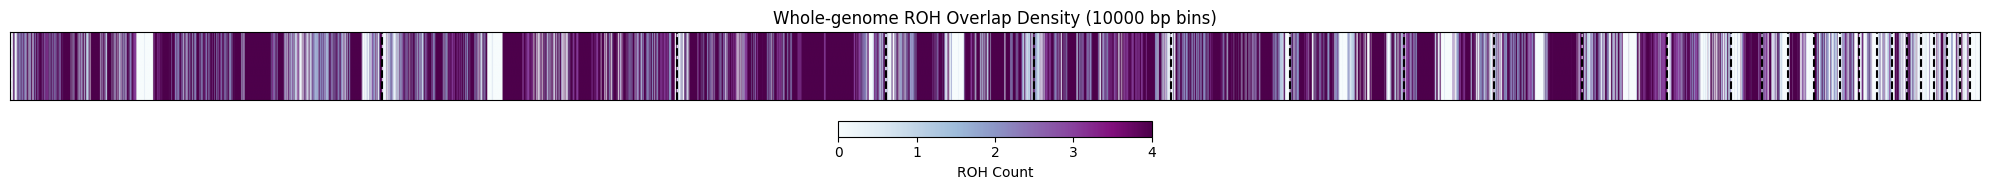

In [21]:
# Group 3
group3_samples = ['TI57', 'TI89', 'TI96', 'TI102']

G3 = TI[TI['Sample'].isin(group3_samples)]

heatmap_df, chrom_sizes, chrom_order = compute_roh_bin_counts(G3, bin_size=10_000)

plot_roh_horizontal_bar(heatmap_df, chrom_sizes, bin_size=10_000, vmax=4)

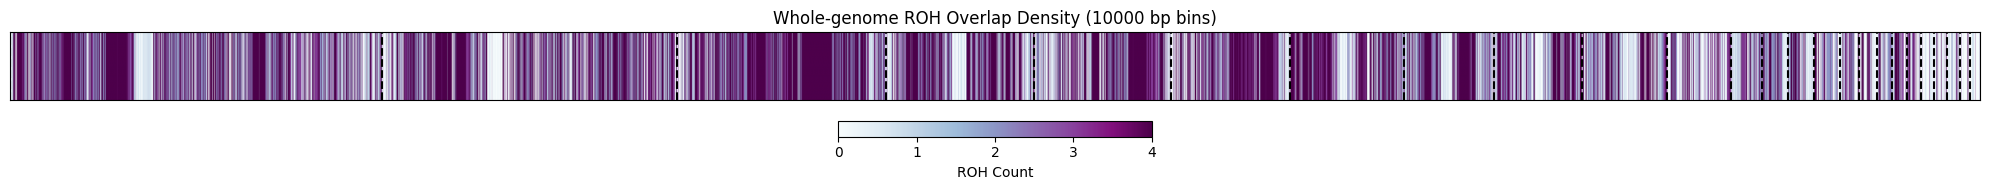

In [22]:
# Group 4
group4_samples = ['TI41', 'TI52', 'TI69', 'TI70']

G4 = TI[TI['Sample'].isin(group4_samples)]

heatmap_df, chrom_sizes, chrom_order = compute_roh_bin_counts(G4, bin_size=10_000)

plot_roh_horizontal_bar(heatmap_df, chrom_sizes, bin_size=10_000, vmax=4)

In [37]:
# Add Group column during concatenation
groups = pd.concat([
    G1.assign(Group='Group 1'),
    G2.assign(Group='Group 2'),
    G3.assign(Group='Group 3'),
    G4.assign(Group='Group 4')
], ignore_index=True)

groupFROH = groups.groupby(['Sample', 'Group', 'Total Segments Included'])['ROH Length'].sum().reset_index(name='ROH Total')
groupFROH['FROH'] = groupFROH['ROH Total'] / groupFROH['Total Segments Included']

groupFROH[groupFROH['Group']=='Group 2'].head(n=11)

,Sample,Group,Total Segments Included,ROH Total,FROH
0,TI100,Group 2,1108950000,761250000,0.686460
3,TI21,Group 2,1024550000,513850000,0.501537
8,TI64,Group 2,1109200000,762200000,0.687162
10,TI66,Group 2,1117050000,776000000,0.694687
16,TI86,Group 2,1103000000,787600000,0.714053
17,TI87,Group 2,1099350000,745550000,0.678173
20,TI95,Group 2,1113200000,783100000,0.703467
22,TI97,Group 2,1112450000,767100000,0.689559


(0.48, 0.75)

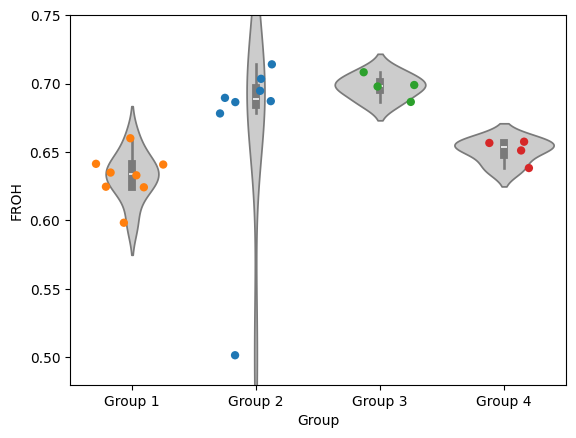

In [39]:
group_order = ['Group 1', 'Group 2', 'Group 3', 'Group 4']

sns.violinplot(data = groupFROH, x = 'Group', y = 'FROH', color='0.8', order=group_order)
sns.stripplot(data = groupFROH, x = 'Group', y = 'FROH', hue = 'Group', jitter = 0.3, size=6, order=group_order)
plt.ylim(0.48, 0.75)

### Individual Heterozygosity (H<sub>o</sub>)
#### SNPs
Here, we implemented a global (genome-wide heterozygosity) method from ANGSD. Essentially, this estimate is a proportion of heterozygous genotypes / genome size (excluding regions of the genome with low confidence). Unlike other runs of ANGSD, individual BAMs are used to estimate hetereozygosity, which is simply second value in the SFS/AFS.

In [ ]:
SAMP=$(sed -n "$((SLURM_ARRAY_TASK_ID + 1))p" /nesi/nobackup/uc03718/angsd/GLOBAL.list)
NAME=$(basename $SAMP _autosomes_nodup.bam)

printf "\nSTARTED RUNNING ANGSD TO ESTIMATE HETEROZYGOSITY FOR $NAME AT "
date

angsd -P 32 -i ${SAMP} -ref $TREF -out ${DIR}samtools/heterozygosity/${NAME} \
        -uniqueOnly 1 -remove_bads 1 -only_proper_pairs 1 -trim 0 -C 50 -angbaq 1 \
        -minMapQ 20 -minQ 20 -doCounts 1 -dosaf 1 -GL 1

realSFS ${DIR}samtools/heterozygosity/${NAME}.saf.ids > ${DIR}samtools/heterozygosity/${NAME}_est.ml

Once the SFS was estimated for each individual, the number of sites was estimated from the sum of all scaffold sizes included in the bam file and output to a file.  

In [ ]:
printf "Sample\tHomozygous Ref Sites\tHeterozygous Sites\tHomozygous Alt Sites\tPopulation\tDataset\n" > ${ANGSD}individual_het.tsv 

for POP in AU TI KI_10x KI
    do
    while read -r line
        do
        SAMP=$(echo $line)
        NEUTRAL_RR=$(awk '{print $1}' ${ANGSD}neutral/heterozygosity/${SAMP}_est.ml)
        NEUTRAL_RA=$(awk '{print $2}' ${ANGSD}neutral/heterozygosity/${SAMP}_est.ml)
        NEUTRAL_AA=$(awk '{print $3}' ${ANGSD}neutral/heterozygosity/${SAMP}_est.ml)
        WGENOME_RR=$(awk '{print $1}' ${ANGSD}samtools/heterozygosity/${SAMP}_est.ml)
        WGENOME_RA=$(awk '{print $2}' ${ANGSD}samtools/heterozygosity/${SAMP}_est.ml)
        WGENOME_AA=$(awk '{print $3}' ${ANGSD}samtools/heterozygosity/${SAMP}_est.ml)
        printf "$SAMP\t$NEUTRAL_RR\t$NEUTRAL_RA\t$NEUTRAL_AA\t${POP}\tneutral\n" >> individual_het.tsv
        printf "$SAMP\t$WGENOME_RR\t$WGENOME_RA\t$WGENOME_AA\t${POP}\twhole-genome\n" >> individual_het.tsv
    done < ${POP}_relatedness_IDs.txt
done

#### SVs
Genotypes for each individual were estimated and then plotted in 06_visualisations.ipynb.  

In [ ]:
while read -r line
    do
    REF=$(bcftools query -s ${line} -i 'GT!="mis" & GQ>=25 & SVMODEL=="AGGREGATED" & FORMAT/FT=="PASS" & GT=="RR"' -f '[%GT\n]' graphtyper/02_fairy_genotypes_filtered.vcf.gz | wc -l)
    HET=$(bcftools query -s ${line} -i 'GT!="mis" & GQ>=25 & SVMODEL=="AGGREGATED" & FORMAT/FT=="PASS" & GT=="het"' -f '[%GT\n]' graphtyper/02_fairy_genotypes_filtered.vcf.gz | wc -l | awk -v var=$TOT '{print $1/var}')
    ALT=$(bcftools query -s ${line} -i 'GT!="mis" & GQ>=25 & SVMODEL=="AGGREGATED" & FORMAT/FT=="PASS" & GT=="AA"' -f '[%GT\n]' graphtyper/02_fairy_genotypes_filtered.vcf.gz | wc -l)
    if [[ "$line" == "AU"* ]]
    then
        printf "$line\t$REF\t$HET\t$ALT\tAU\n"
        printf "$line\t$REF\t$HET\t$ALT\tAU\n" >> graphtyper/individual_svHet.tsv
    else
        printf "$line\t$REF\t$HET\t$ALT\tTI\n"
        printf "$line\t$REF\t$HET\t$ALT\tTI\n" >> graphtyper/individual_svHet.tsv
    fi
done < samples.txt

### SNP- and SV-based *H<sub>O</sub>* Estimates
The next diversity metric we examined was individual observed heterozygosity. SNPs were estimated using `ANGSD` and `realSFS` for all sites and putatively neutral sites where we excluded regions predicted to be coding regions by `AUGUSTUS`.  

We estimated structural variant heterozygosity as:
$$
H_{O} = \frac{\sum{H Sites}}{\sum{Genotyped Sites}}
$$

To examine the impact of read depth on SNPs and SVs, we leveraged the heterozygosity estimated using Australian fairy tern, tara iti, kakī subsampled alignments and high coverage kakī alignments. For esimtates of SV heterozygosity, we filtered out all invariant sites in the Australian fairy tern and tara iti populations. This included fixed SVs in Australian fairy terns.   

In [58]:
sv_het = pd.read_csv('smoove/sv_het.tsv', delimiter='\t')

sv_het.tail()

,Sample,Homozygous Reference,Heterozygous,Homozygous Alternate,Population
169,H01402,1167,673,348,KI
170,H01403,1196,696,296,KI
171,H01404,1286,738,164,KI
172,H01405,1304,605,279,KI
173,H01406,1091,781,316,KI


### Kakī SV Mendelian Inheritance
Here we examine the number of sites adhering to mendelian inheritance expectations in X trios for 3 data sets filtered for genotyping quality:
1) SVs discovered and genotyped using high coverage data
2) SVs discovered using high coverage data, and genotyped using subset data
3) SVs discovered and genotyped using subset data

Here, high coverage data is ranging from ~22x - ~67x alignment depth while subset data represents aligned depths ranging from ~6x = ~13x.  

In [ ]:
kiSVmendel = pd.read_csv('graphtyper/graphtyper_kaki_subset/KI_mendelian_counts.tsv', sep='\t')

kiSVmendel.head()

In [ ]:
kiSVmendel.groupby(['Data set'])['Percent Failing'].mean().reset_index()

Here, we are briefly examining the average proportion of SVs in either a homozygous reference or alternate state in Australian fairy tern, tara iti, and subsampled kakī data sets.  

Text(0.0, 1.0, 'B)')

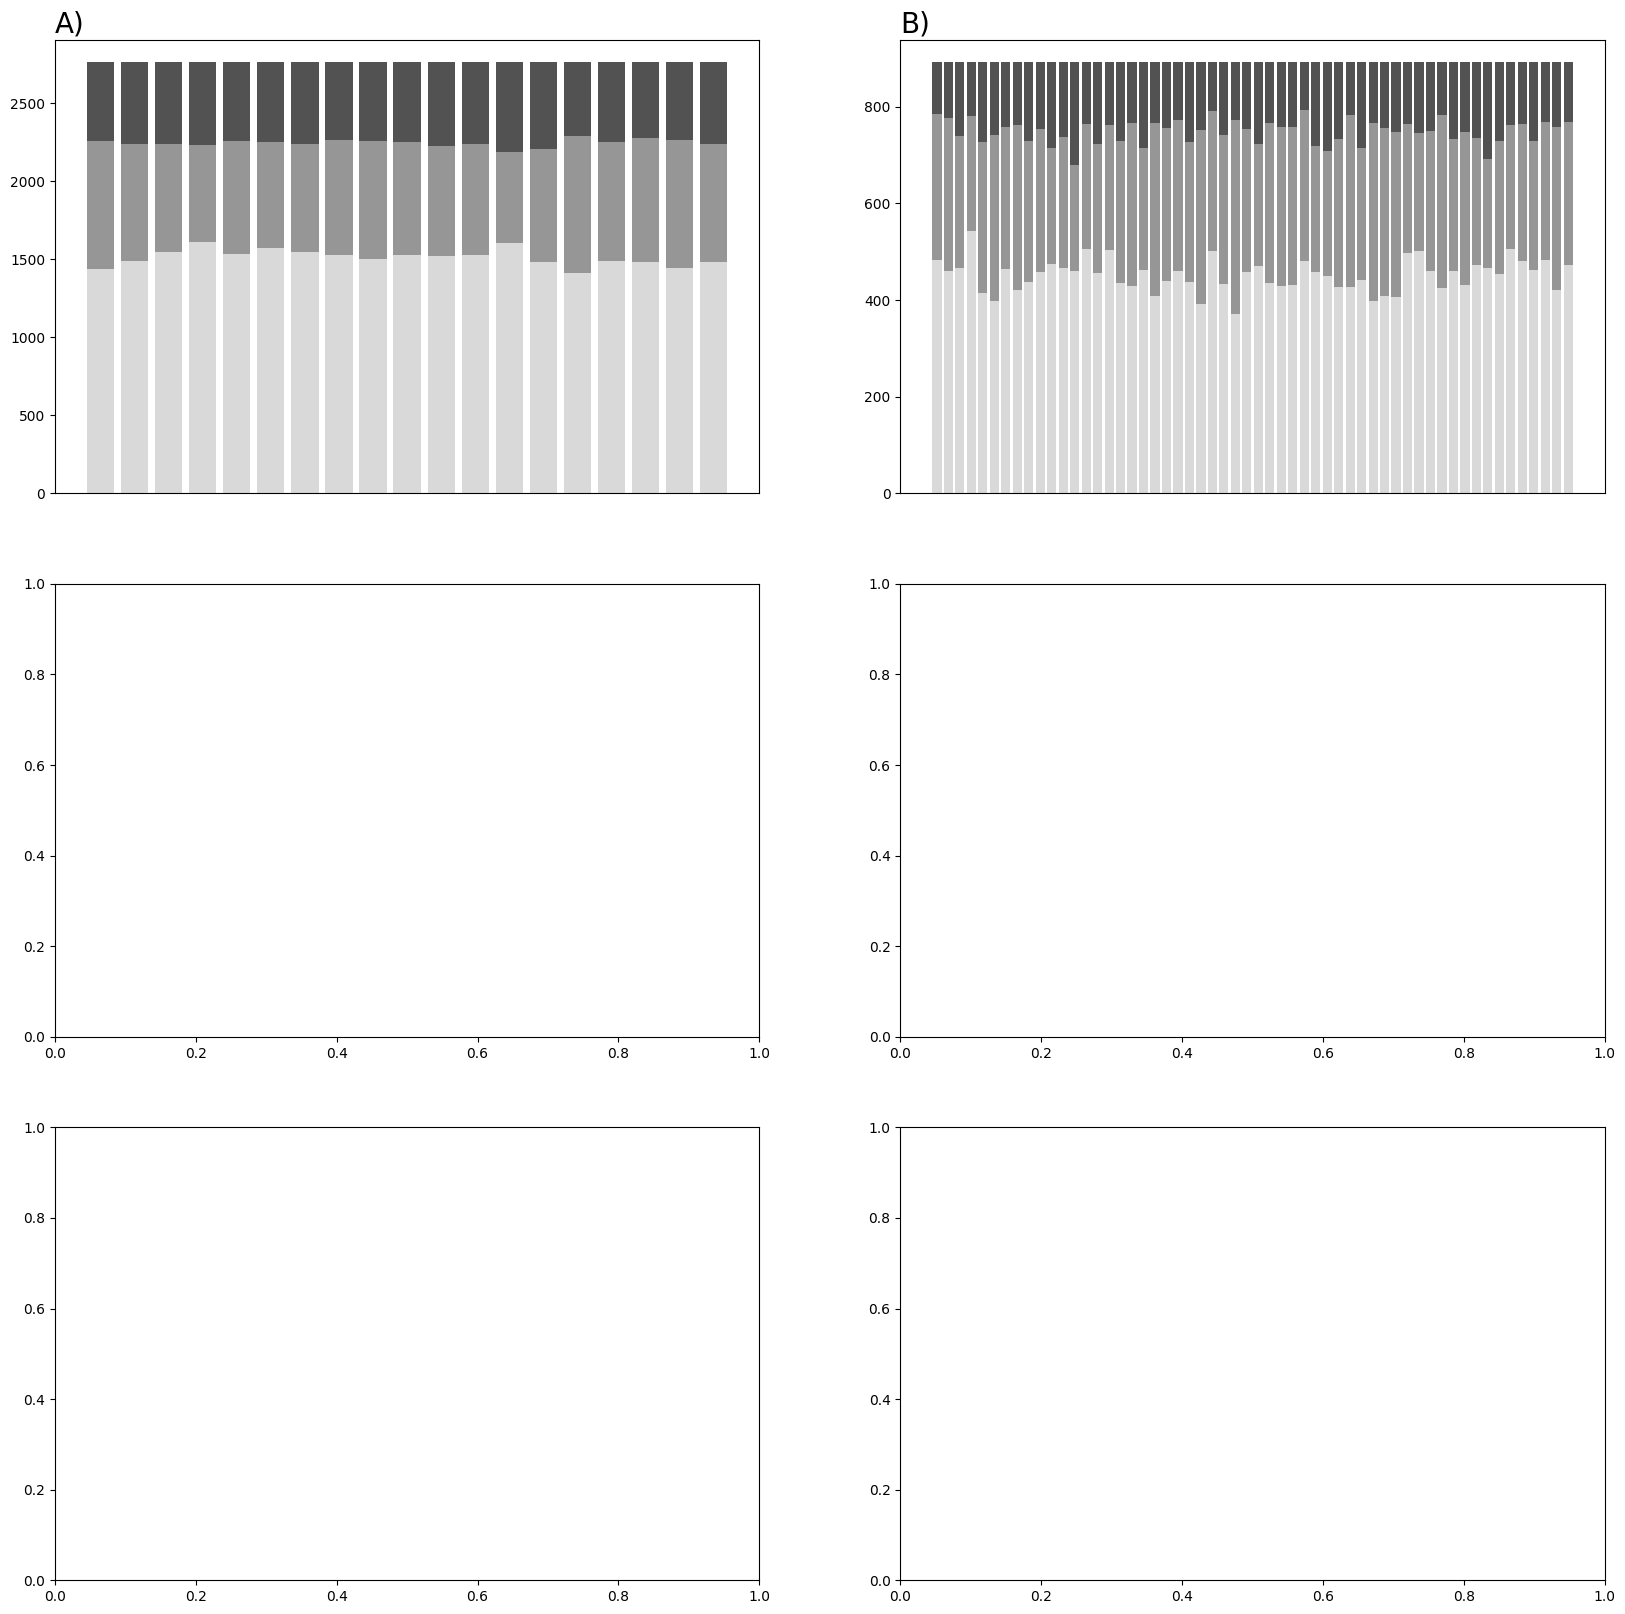

In [ ]:
sv_het = pd.read_csv('smoove/sv_het.tsv', delimiter='\t')
#kiSVmendel = kiSVmendel[kiSVmendel['Data set']!='50xSVs_10xGenotypes']

order = ['KI_10x', '50xSVs_50xGenotypes']

# Grayscale colors for the three categories
colors = ['#d9d9d9', '#969696', '#525252']  # Light, medium, and dark gray

# Create subplots
fig, axes = plt.subplots(3, 2, figsize=(20, 20), sharex=False, sharey=False)  # 1 row, 4 columns, shared y-axis

au_svHet = sv_het[sv_het['Population'] == 'AU']  # Filter for the current population
ti_svHet = sv_het[sv_het['Population'] == 'NZ']
#kiLC_svHet = sv_het[sv_het['Population'] == 'KI_10x']
#kiHC_svHet = sv_het[sv_het['Population'] == 'KI']
aux = np.arange(len(au_svHet))
tix = np.arange(len(ti_svHet))
#kix = np.arange(len(kiLC_svHet))

# Plot stacked bars
axes[0,0].bar(aux, au_svHet['Homozygous Reference'], label='Homozygous Reference', color=colors[0])
axes[0,0].bar(aux, au_svHet['Heterozygous'], bottom=au_svHet['Homozygous Reference'], label='Heterozygous', color=colors[1])
axes[0,0].bar(aux, au_svHet['Homozygous Alternate'], bottom=au_svHet['Homozygous Reference'] + au_svHet['Heterozygous'], label='Homozygous Alt', color=colors[2])
axes[0,0].set_xticks([])
axes[0,0].set_title('A)', fontsize = 20, loc='left')
#axes[0,0].set_ylim(0,1800)

axes[0,1].bar(tix, ti_svHet['Homozygous Reference'], label='Homozygous Reference', color=colors[0])
axes[0,1].bar(tix, ti_svHet['Heterozygous'], bottom=ti_svHet['Homozygous Reference'], label='Heterozygous', color=colors[1])
axes[0,1].bar(tix, ti_svHet['Homozygous Alternate'], bottom=ti_svHet['Homozygous Reference'] + ti_svHet['Heterozygous'], label='Homozygous Alternate', color=colors[2])
axes[0,1].set_xticks([])
axes[0,1].set_title('B)', fontsize = 20, loc='left')
#axes[0,1].set_ylim(0,1800)

#axes[1,0].bar(kix, kiLC_svHet['Homozygous Reference'], label='Homozygous Reference', color=colors[0])
#axes[1,0].bar(kix, kiLC_svHet['Heterozygous'], bottom=kiLC_svHet['Homozygous Reference'], label='Heterozygous', color=colors[1])
#axes[1,0].bar(kix, kiLC_svHet['Homozygous Alternate'], bottom=kiLC_svHet['Homozygous Reference'] + kiLC_svHet['Heterozygous'], label='Homozygous Alternate', color=colors[2])
#axes[1,0].set_xticks([])
#axes[1,0].set_title('C)', fontsize = 20, loc='left')
#axes[1,0].set_ylim(0,1800)

#axes[1,1].bar(kix, kiHC_svHet['Homozygous Reference'], label='Homozygous Reference', color=colors[0])
#axes[1,1].bar(kix, kiHC_svHet['Heterozygous'], bottom=kiHC_svHet['Homozygous Reference'], label='Heterozygous', color=colors[1])
#axes[1,1].bar(kix, kiHC_svHet['Homozygous Alternate'], bottom=kiHC_svHet['Homozygous Reference'] + kiHC_svHet['Heterozygous'], label='Homozygous Alternate', color=colors[2])
#axes[1,1].set_xticks([])
#axes[1,1].set_title('D)', fontsize = 20, loc='left')
#axes[1,1].set_ylim(0,1800)

#plt.savefig('TI_ms_plots/Figure_2a.pdf', dpi=300, bbox_inches='tight')

In [ ]:
kiSVmendel = kiSVmendel[kiSVmendel['Data set']!='50xSVs_10xGenotypes']

order = ['10xSVs_10xGenotypes', '50xSVs_50xGenotypes']

plt.figure(figsize=(10, 5))

sns.violinplot(data=kiSVmendel, x='Data set', y='Percent Failing', color='0.8', order=order)
sns.stripplot(data=kiSVmendel, x='Data set', y='Percent Failing', jitter=True, color='black', order=order)
plt.xticks(['10xSVs_10xGenotypes', '50xSVs_50xGenotypes'], ['KĪ low', 'KĪ high'], fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(0, 18)
plt.ylabel('Percent Failing Sites', fontsize = 18)
plt.xlabel('')
plt.title('E)', fontsize = 20, loc='left')

plt.savefig('TI_ms_plots/Figure_2b.pdf', dpi=300, bbox_inches='tight')

Here, we are briefly examining the average proportion of SVs in either a homozygous reference or alternate state in Australian fairy tern, tara iti, and subsampled kakī data sets.  

In [ ]:
sv_het = pd.read_csv('graphtyper/individual_svHet.tsv', delimiter='\t')

print("Mean proportion of homozygous alternate sites in AFT: ", sv_het[sv_het['Population']=='AU']['Proportion Alt'].mean())
print("Mean proportion of homozygous alternate sites in TI: ", sv_het[sv_het['Population']=='TI']['Proportion Alt'].mean())
print("Mean proportion of homozygous alternate sites in KI low: ", sv_het[sv_het['Population']=='KI_10x']['Proportion Alt'].mean())
print("Mean proportion of homozygous alternate sites in KI high: ", sv_het[sv_het['Population']=='KI']['Proportion Alt'].mean())

print("Mean proportion of homozygous reference sites in AFT: ", sv_het[sv_het['Population']=='AU']['Proportion Ref'].mean())
print("Mean proportion of homozygous reference sites in TI: ", sv_het[sv_het['Population']=='TI']['Proportion Ref'].mean())
print("Mean proportion of homozygous reference sites in KI low: ", sv_het[sv_het['Population']=='KI_10x']['Proportion Ref'].mean())
print("Mean proportion of homozygous reference sites in KI high: ", sv_het[sv_het['Population']=='KI']['Proportion Ref'].mean())

In [59]:
indiv_het = pd.read_csv('angsd/individual_het.tsv', delimiter='\t')
indiv_het = indiv_het.sort_values(by=['Sample', 'Population'], ascending=[True, True])
indiv_het['Heterozygosity'] = indiv_het['Heterozygous Sites'] / (indiv_het['Homozygous Ref Sites'] + indiv_het['Heterozygous Sites'] + indiv_het['Homozygous Alt Sites'] )
neutral_het = indiv_het[indiv_het['Dataset'] == 'neutral']

neutral_het.head()

,Sample,Homozygous Ref Sites,Heterozygous Sites,Homozygous Alt Sites,Population,Dataset,Heterozygosity
0,AU01,5.546062e+08,263594.796810,1.170285e+07,AU,neutral,0.000465
2,AU03,5.534277e+08,234043.744266,1.164816e+07,AU,neutral,0.000414
4,AU04,5.513811e+08,225557.382068,1.155151e+07,AU,neutral,0.000401
6,AU06,5.502594e+08,194723.440327,1.152173e+07,AU,neutral,0.000346
8,AU08,5.517146e+08,223312.949336,1.157205e+07,AU,neutral,0.000396


For relative comparisons of diversity, examined individual heterozygosity for SNPs (A) in Australian fairy tern, tara iti and high coverage kakī data sets, and SVs (B) jointly called and genotyped in fairy terns (i.e., including sites fixed in either population), as well as individual ROH counts (C) and ROH proportions (D) for all three groups.  

In [60]:
neutral_het.tail()

,Sample,Homozygous Ref Sites,Heterozygous Sites,Homozygous Alt Sites,Population,Dataset,Heterozygosity
136,TI95,5.676111e+08,56867.328473,1.242076e+07,NZ,neutral,0.000098
138,TI96,5.694877e+08,61444.276373,1.251298e+07,NZ,neutral,0.000106
140,TI97,5.679411e+08,57875.685026,1.243382e+07,NZ,neutral,0.000100
142,TI98,5.691189e+08,78391.013193,1.248757e+07,NZ,neutral,0.000135
144,TI99,5.700556e+08,71735.624669,1.253719e+07,NZ,neutral,0.000123


In [77]:
indiv_het = pd.read_csv('angsd/individual_het.tsv', delimiter='\t')
indiv_het = indiv_het.sort_values(by=['Sample', 'Population'], ascending=[True, True])
indiv_het['Heterozygosity'] = indiv_het['Heterozygous Sites'] / (indiv_het['Homozygous Ref Sites'] + indiv_het['Heterozygous Sites'] + indiv_het['Homozygous Alt Sites'])
neutral_het = indiv_het[indiv_het['Dataset'] == 'neutral']

sv_het = pd.read_csv('smoove/sv_het.tsv', delimiter='\t')
sv_het['Heterozygosity'] = sv_het['Heterozygous'] / (sv_het['Homozygous Reference'] + sv_het['Heterozygous'] + sv_het['Homozygous Alternate'])

sv_fairyhet = sv_het[(sv_het['Population'] == 'AU_GLOBAL') | (sv_het['Population'] == 'NZ_GLOBAL')]
sv_var_het = sv_het[(sv_het['Population'] == 'AU') | (sv_het['Population'] == 'NZ') | (sv_het['Population'] == 'KI')]

roh = pd.read_csv('rohan/ROHs.tsv', sep='\t')
roh_segments = pd.read_csv('rohan/ROH_segment_summary.txt', sep='\t')

roh_summary = roh[['Sample', 'Size Class', 'Population']]
roh_summary = roh_summary.groupby(['Sample', 'Size Class', 'Population']).size().reset_index(name='ROH Counts')
roh_summary = roh_summary.sort_values('Size Class', ascending=False)

roh_len = roh[['Sample', 'ROH Length', 'Size Class', 'Population']]
roh_len = roh_len.groupby(['Sample', 'Size Class', 'Population'])['ROH Length'].sum().reset_index(name='ROH Total')

roh_segments['Total Segments Included'] = roh_segments['Segments in ROH'] + roh_segments['Segments in non-ROH']

roh_len = roh_len.merge(roh_segments[['Sample', 'Total Segments Included']], on='Sample', how='left')

roh_len['Proportion'] = roh_len['ROH Total'] / roh_len['Total Segments Included']

roh_len = roh_len.sort_values('Size Class', ascending=False)

In [62]:
print(sv_fairyhet)

   Sample  Homozygous Reference  Heterozygous  Homozygous Alternate  \
0    AU01                  1875           852                  2158   
1    AU03                  1932           772                  2181   
2    AU04                  2002           708                  2175   
3    AU06                  2055           639                  2191   
4    AU08                  1973           750                  2162   
..    ...                   ...           ...                   ...   
70   TI95                  4456           294                   135   
71   TI96                  4442           270                   173   
72   TI97                  4455           294                   136   
73   TI98                  4394           346                   145   
74   TI99                  4446           304                   135   

   Population  Heterozygosity  
0   AU_GLOBAL        0.174411  
1   AU_GLOBAL        0.158035  
2   AU_GLOBAL        0.144933  
3   AU_GLOBAL      

/tmp/ipykernel_7431/1069506228.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(['AFT', 'NZ', 'KĪ'], fontsize=22, rotation=45)
/tmp/ipykernel_7431/1069506228.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(['AFT', 'NZ', 'KĪ'], fontsize=20, rotation=45)


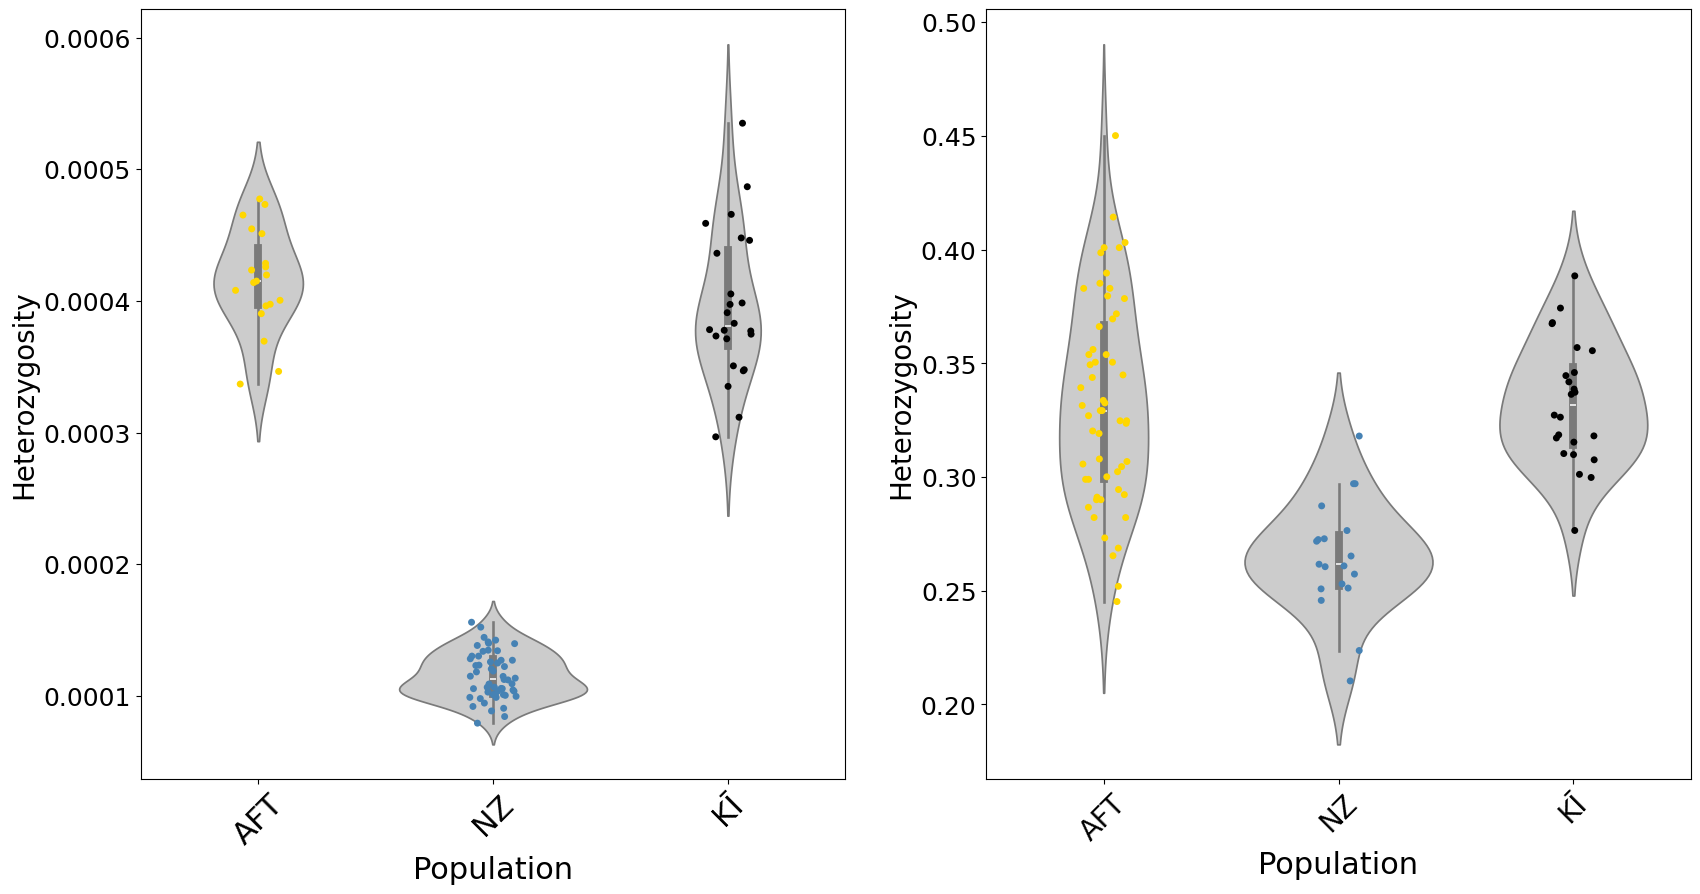

In [78]:
xvalues = ["Short ROHs", "Medium ROHs", "Long ROHs"]
palette = ['gold', 'steelblue', 'grey', 'black']
palette = ['gold', 'steelblue', 'black']
order = ['AU', 'NZ', 'KI_10x', 'KI']
order = ['AU', 'NZ', 'KI']

fig, axes = plt.subplots(1, 2, figsize=(20, 10), sharex=False, sharey=False)

# SNP heterozygosity
sns.violinplot(data = neutral_het[neutral_het['Population']!='KI_10x'], x = "Population", y = "Heterozygosity", order=order, color="0.8", ax=axes[0])
sns.stripplot(data = neutral_het[neutral_het['Population']!='KI_10x'], x = "Population", y = "Heterozygosity", hue = "Population", hue_order=order, palette=palette, jitter = True, size=5, ax=axes[0])
axes[0].set_xticklabels(['AFT', 'NZ', 'KĪ'], fontsize=22, rotation=45)
axes[0].set_xlabel('Population', fontsize=22)
axes[0].set_ylabel("Heterozygosity", fontsize=20)
axes[0].tick_params(axis='y', which='major', labelsize=18)

# Variable SV heterozygosity
sns.violinplot(data = sv_var_het, x = 'Population', y = 'Heterozygosity', color='0.8', ax=axes[1])
sns.stripplot(data = sv_var_het, x = 'Population', y = 'Heterozygosity', hue = 'Population', palette=palette, jitter = True, size=5, ax=axes[1])
axes[1].set_xticklabels(['AFT', 'NZ', 'KĪ'], fontsize=20, rotation=45)
axes[1].set_xlabel('Population', fontsize=22)
axes[1].set_ylabel('Heterozygosity', fontsize=20)
axes[1].tick_params(axis='y', which='major', labelsize=18)

plt.savefig('TI_ms_plots/HET_comparisons.png', dpi=300, bbox_inches='tight')

/tmp/ipykernel_7431/3450999039.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(['Short', 'Medium', 'Large'], fontsize=20)
/tmp/ipykernel_7431/3450999039.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(['Short', 'Medium', 'Large'], fontsize=22)


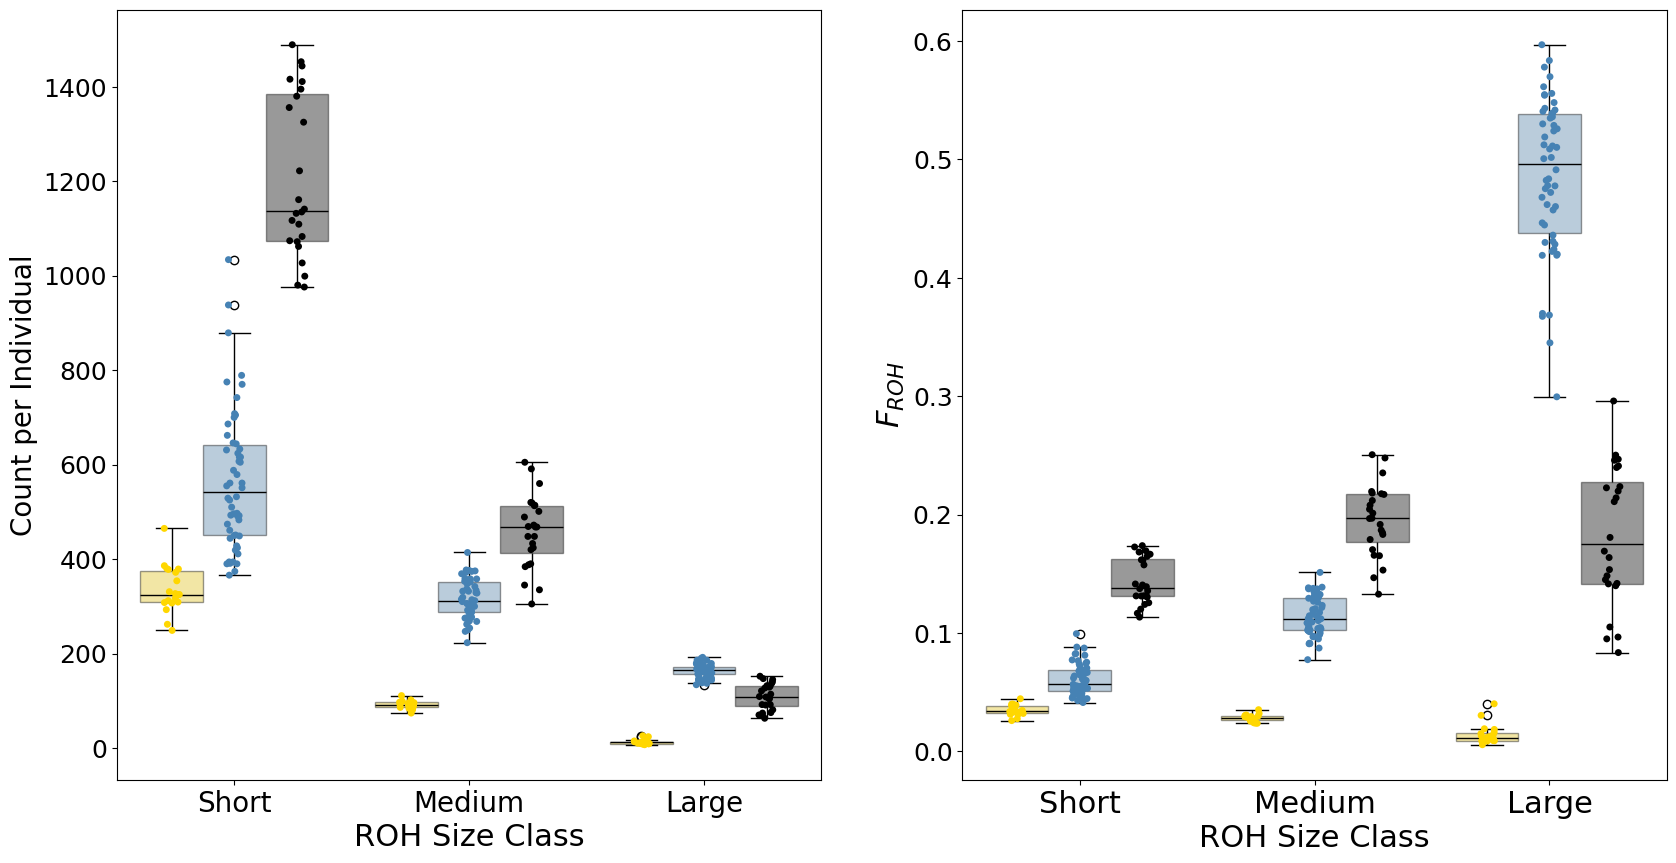

In [74]:
xvalues = ["Short ROHs", "Medium ROHs", "Long ROHs"]
palette = ['gold', 'steelblue', 'grey', 'black']
palette = ['gold', 'steelblue', 'black']
order = ['AU', 'NZ', 'KI_10x', 'KI']
order = ['AU', 'NZ', 'KI']

fig, axes = plt.subplots(1, 2, figsize=(20, 10), sharex=False, sharey=False)

# ROH Count
sns.boxplot(data=roh_summary, x="Size Class", y="ROH Counts", hue="Population", palette=palette, hue_order=order, boxprops={'alpha': 0.4},ax=axes[0], legend=False)
sns.stripplot(data=roh_summary, x="Size Class", y="ROH Counts", hue="Population", palette=palette, hue_order=order, dodge=True, ax=axes[0], legend=False)
#axes[0].set_title('D)', loc='left', fontsize=42)
axes[0].set_xticklabels(['Short', 'Medium', 'Large'], fontsize=20)
axes[0].set_xlabel('ROH Size Class', fontsize=22)
axes[0].set_ylabel("Count per Individual", fontsize=20)
axes[0].tick_params(axis='y', which='major', labelsize=18)

# ROH Proportion
sns.boxplot(data=roh_len, x="Size Class", y="Proportion", hue="Population", palette=palette, hue_order=order, boxprops={'alpha': 0.4}, ax=axes[1], legend=False)
sns.stripplot(data=roh_len, x="Size Class", y="Proportion", hue="Population", palette=palette, hue_order=order, dodge=True, ax=axes[1], legend=False)
#axes[1].set_title('E)', loc='left', fontsize=42)
axes[1].set_xticklabels(['Short', 'Medium', 'Large'], fontsize=22)
axes[1].set_xlabel('ROH Size Class', fontsize=22)
axes[1].set_ylabel("$F_{ROH}$", fontsize=22)
axes[1].tick_params(axis='y', which='major', labelsize=18)

plt.savefig('TI_ms_plots/ROH_comparisons.png', dpi=300, bbox_inches='tight')

/tmp/ipykernel_7431/3519444637.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(['AFT', 'NZ', 'KĪ'], fontsize=22, rotation=45)
/tmp/ipykernel_7431/3519444637.py:20: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.stripplot(data = sv_fairyhet, x = 'Population', y = 'Heterozygosity', hue = 'Population', palette=palette, jitter = True, size=5, ax=axes[1])
/tmp/ipykernel_7431/3519444637.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(['AFT', 'TI'], fontsize=22, rotation=45)
/tmp/ipykernel_7431/3519444637.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[2].set_xticklabels(['AFT', 'NZ', 'KĪ'], fontsize=20, rotation=45)
/tmp/ipyk

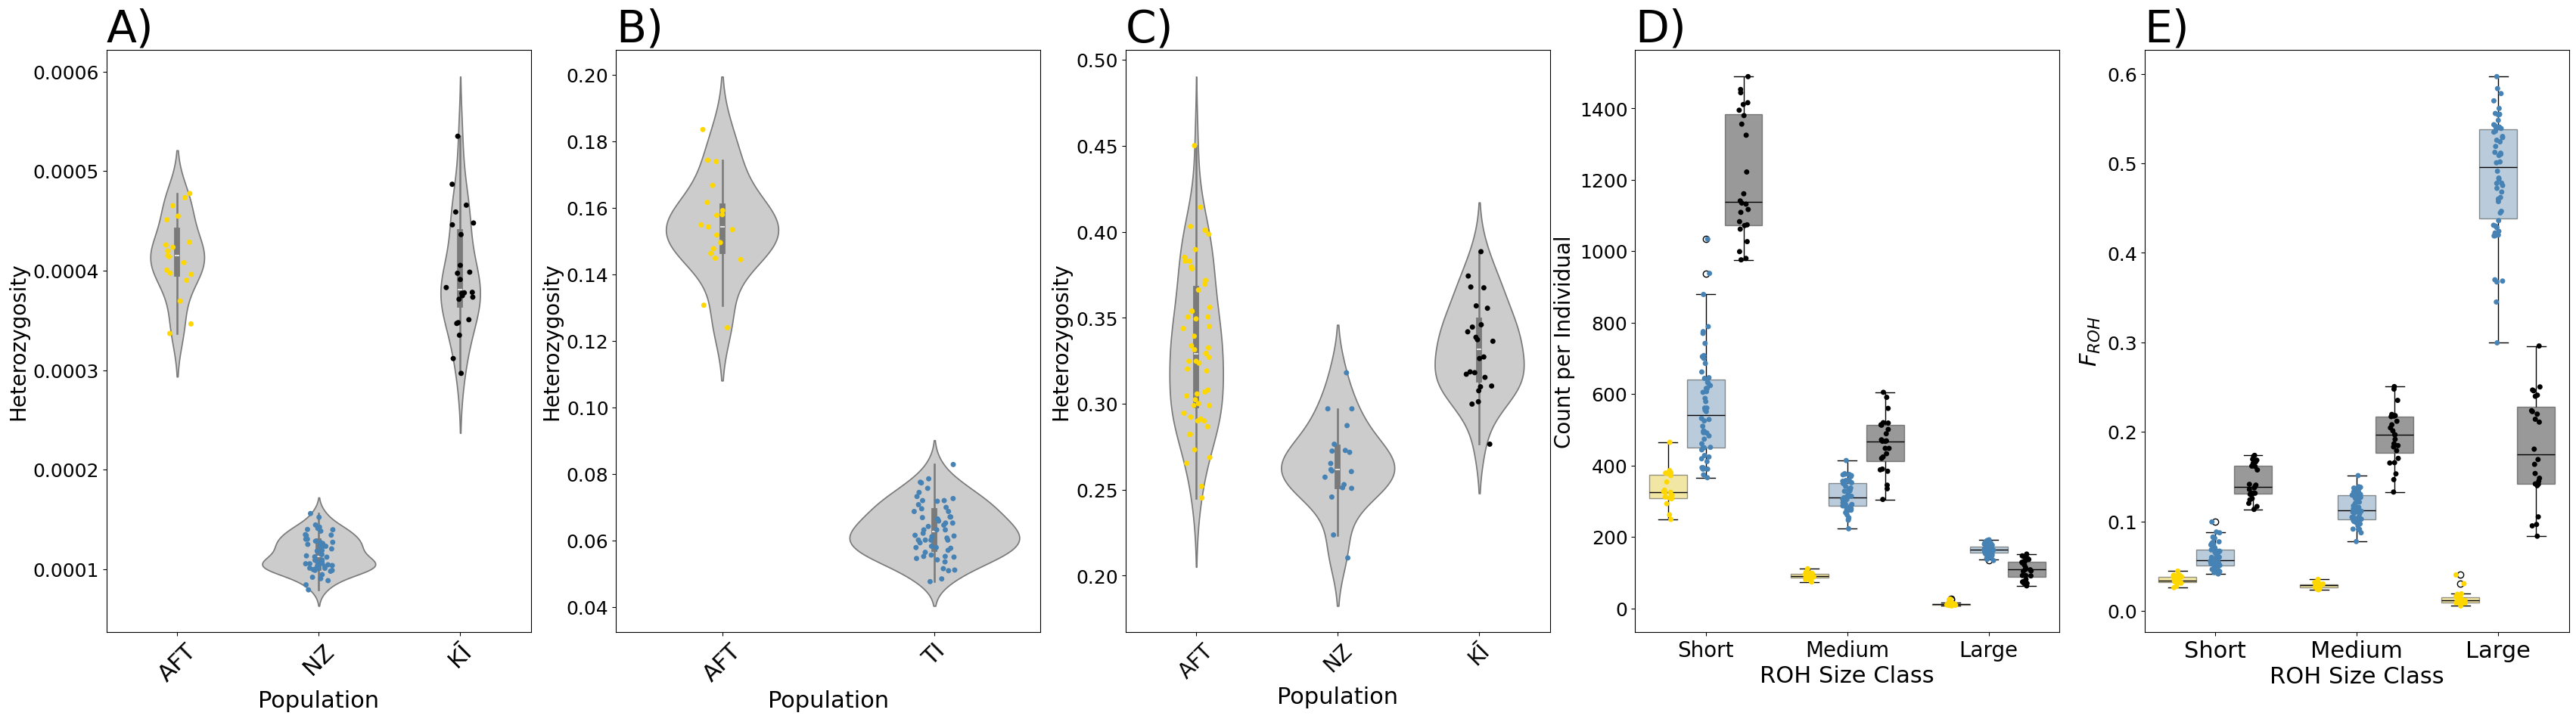

In [79]:
xvalues = ["Short ROHs", "Medium ROHs", "Long ROHs"]
palette = ['gold', 'steelblue', 'grey', 'black']
palette = ['gold', 'steelblue', 'black']
order = ['AU', 'NZ', 'KI_10x', 'KI']
order = ['AU', 'NZ', 'KI']

fig, axes = plt.subplots(1, 5, figsize=(42, 10), sharex=False, sharey=False)

# SNP heterozygosity
sns.violinplot(data = neutral_het[neutral_het['Population']!='KI_10x'], x = "Population", y = "Heterozygosity", order=order, color="0.8", ax=axes[0])
sns.stripplot(data = neutral_het[neutral_het['Population']!='KI_10x'], x = "Population", y = "Heterozygosity", hue = "Population", hue_order=order, palette=palette, jitter = True, size=5, ax=axes[0])
axes[0].set_title('A)', loc='left', fontsize=42)
axes[0].set_xticklabels(['AFT', 'NZ', 'KĪ'], fontsize=22, rotation=45)
axes[0].set_xlabel('Population', fontsize=22)
axes[0].set_ylabel("Heterozygosity", fontsize=20)
axes[0].tick_params(axis='y', which='major', labelsize=18)

# GLOBAL Fairy SV heterozygosity
sns.violinplot(data = sv_fairyhet, x = 'Population', y = 'Heterozygosity', color='0.8', ax=axes[1])
sns.stripplot(data = sv_fairyhet, x = 'Population', y = 'Heterozygosity', hue = 'Population', palette=palette, jitter = True, size=5, ax=axes[1])
axes[1].set_title('B)', loc='left', fontsize=42)
axes[1].set_xticklabels(['AFT', 'TI'], fontsize=22, rotation=45)
axes[1].set_xlabel('Population', fontsize=22)
axes[1].set_ylabel('Heterozygosity', fontsize=20)
axes[1].tick_params(axis='y', which='major', labelsize=18)

# Variable SV heterozygosity
sns.violinplot(data = sv_var_het, x = 'Population', y = 'Heterozygosity', color='0.8', ax=axes[2])
sns.stripplot(data = sv_var_het, x = 'Population', y = 'Heterozygosity', hue = 'Population', palette=palette, jitter = True, size=5, ax=axes[2])
axes[2].set_title('C)', loc='left', fontsize=42)
axes[2].set_xticklabels(['AFT', 'NZ', 'KĪ'], fontsize=20, rotation=45)
axes[2].set_xlabel('Population', fontsize=22)
axes[2].set_ylabel('Heterozygosity', fontsize=20)
axes[2].tick_params(axis='y', which='major', labelsize=18)

# ROH Count
sns.boxplot(data=roh_summary, x="Size Class", y="ROH Counts", hue="Population", palette=palette, hue_order=order, boxprops={'alpha': 0.4},ax=axes[3], legend=False)
sns.stripplot(data=roh_summary, x="Size Class", y="ROH Counts", hue="Population", palette=palette, hue_order=order, dodge=True, ax=axes[3], legend=False)
axes[3].set_title('D)', loc='left', fontsize=42)
axes[3].set_xticklabels(['Short', 'Medium', 'Large'], fontsize=20)
axes[3].set_xlabel('ROH Size Class', fontsize=22)
axes[3].set_ylabel("Count per Individual", fontsize=20)
axes[3].tick_params(axis='y', which='major', labelsize=18)

# ROH Proportion
sns.boxplot(data=roh_len, x="Size Class", y="Proportion", hue="Population", palette=palette, hue_order=order, boxprops={'alpha': 0.4}, ax=axes[4], legend=False)
sns.stripplot(data=roh_len, x="Size Class", y="Proportion", hue="Population", palette=palette, hue_order=order, dodge=True, ax=axes[4], legend=False)
axes[4].set_title('E)', loc='left', fontsize=42)
axes[4].set_xticklabels(['Short', 'Medium', 'Large'], fontsize=22)
axes[4].set_xlabel('ROH Size Class', fontsize=22)
axes[4].set_ylabel("$F_{ROH}$", fontsize=22)
axes[4].tick_params(axis='y', which='major', labelsize=18)

plt.savefig('TI_ms_plots/Figure_3.png', dpi=300, bbox_inches='tight')

Significance of differences in individual heterozygosity.  

In [ ]:
def mann_whitney_test(df, group_col, value_col, group1, group2):
    group1_values = df[df[group_col] == group1][value_col]
    group2_values = df[df[group_col] == group2][value_col]
    stat, p_value = mannwhitneyu(group1_values, group2_values, alternative='two-sided')
    return stat, p_value

groups = ['AU', 'TI', 'KI_10x', 'KI']
results_total = {}

for i in range(len(groups)):
    for j in range(i + 1, len(groups)):
        group1 = groups[i]
        group2 = groups[j]
        stat, p_value = mann_whitney_test(neutral_het, 'Population', 'Heterozygosity', group1, group2)
        results_total[f'{group1} vs {group2}'] = {'stat': stat, 'p_value': p_value}

# Print the results
print("Mann-Whitney U Test results for SNP heterozygosity:")
for comparison, result in results_total.items():
    print(f"{comparison}: U-statistic = {result['stat']}, p-value = {result['p_value']}")

for i in range(len(groups)):
    standard_dev = neutral_het[neutral_het['Population']==groups[i]]['Heterozygosity'].std()
    count = neutral_het[neutral_het['Population']==groups[i]]['Heterozygosity'].count()
    standard_err = standard_dev / np.sqrt(count)
    print(f"Mean individual SNP heterozygosity for {groups[i]}: {neutral_het[neutral_het['Population']==groups[i]]['Heterozygosity'].mean()} +/- {standard_err}")

In [ ]:
sv_het = pd.read_csv('graphtyper/individual_svHet.tsv', delimiter='\t')

def mann_whitney_test(df, group_col, value_col, group1, group2):
    group1_values = df[df[group_col] == group1][value_col]
    group2_values = df[df[group_col] == group2][value_col]
    stat, p_value = mannwhitneyu(group1_values, group2_values, alternative='two-sided')
    return stat, p_value

groups = ['AU', 'TI', 'KI_10x', 'KI', 'AU_sites', 'TI_sites']
results_total = {}

for i in range(len(groups)):
    for j in range(i + 1, len(groups)):
        group1 = groups[i]
        group2 = groups[j]
        stat, p_value = mann_whitney_test(sv_het, 'Population', 'Heterozygosity', group1, group2)
        results_total[f'{group1} vs {group2}'] = {'stat': stat, 'p_value': p_value}

# Print the results
print("Mann-Whitney U Test results for SV heterozygosity:")
for comparison, result in results_total.items():
    print(f"{comparison}: U-statistic = {result['stat']}, p-value = {result['p_value']}")

for i in range(len(groups)):
    standard_dev = sv_het[sv_het['Population']==groups[i]]['Heterozygosity'].std()
    count = sv_het[sv_het['Population']==groups[i]]['Heterozygosity'].count()
    standard_err = standard_dev / np.sqrt(count)
    print(f"Mean individual SV heterozygosity for {groups[i]}: {sv_het[sv_het['Population']==groups[i]]['Heterozygosity'].mean()} +/- {standard_err}")

### *F<sub>ROH</sub>* Relationship with H<sub>o</sub>


In [16]:
def add_trendline_and_r2_by_hue(ax, df, x_col, y_col, hue_col):
    trendline_labels = []
    for hue_value in df[hue_col].unique():
        subset = df[df[hue_col] == hue_value]
        # Fit the linear regression model
        slope, intercept, r_value, p_value, std_err = linregress(subset[x_col], subset[y_col])
        trendline = slope * subset[x_col] + intercept
        ax.plot(subset[x_col], trendline, label=f'{hue_value} trendline', linewidth=2)
        
        # Collect trendline labels for a separate legend
        trendline_labels.append(f'{hue_value} trendline')

        # Calculate R^2
        r_squared = r_value ** 2
        
        # Display R^2 on the plot
        ax.text(0.05, 0.95 - 0.05 * list(df[hue_col].unique()).index(hue_value), f'{hue_value} $R^2 = {r_squared:.2f}$', transform=ax.transAxes, fontsize=14, verticalalignment='bottom')

In [17]:
from scipy.stats import linregress

def add_trendline_and_r2_by_hue(ax, df, x_col, y_col, hue_col):
    # Initialize vertical placement for R^2 labels
    vertical_offset = 0.05
    hue_order = sorted(df[hue_col].unique())  # Ensure consistent order for hues
    
    for hue_index, hue_value in enumerate(hue_order):
        subset = df[df[hue_col] == hue_value]
        
        # Fit the linear regression model
        slope, intercept, r_value, p_value, std_err = linregress(subset[x_col], subset[y_col])
        trendline = slope * subset[x_col] + intercept
        ax.plot(subset[x_col], trendline, label=f'{hue_value} trendline', linewidth=2)
        
        # Calculate R^2
        r_squared = r_value ** 2
        
        # Display R^2 on the plot in the bottom-left corner
        ax.text(
            0.05, 
            0.05 + vertical_offset * hue_index,  # Offset each label vertically
            f'{hue_value}: $R^2 = {r_squared:.2f}$',
            transform=ax.transAxes,
            fontsize=10,
            verticalalignment='bottom',
            horizontalalignment='left'
        )

    # Add a legend for the trendlines
    ax.legend()

TypeError: add_trendline_and_r2_by_hue() missing 1 required positional argument: 'hue_col'

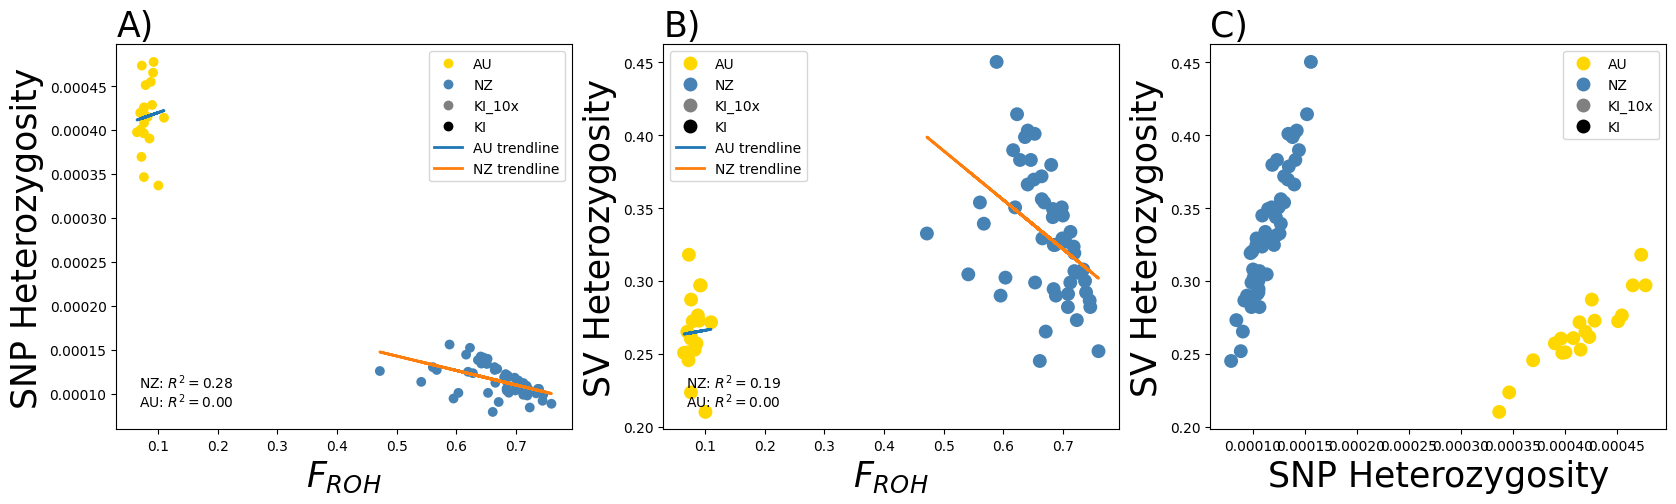

In [28]:
palette = ['gold', 'steelblue', 'grey', 'black']

roh = pd.read_csv('rohan/ROHs.tsv', sep='\t')

roh_len = roh.groupby(['Sample', 'Size Class', 'Population'])['ROH Length'].sum().reset_index(name='ROH Total')
roh_len['Froh'] = roh_len['ROH Total'] / 1088797119

het = pd.read_csv('angsd/individual_het.tsv', delimiter='\t')
het['Heterozygosity'] = het['Heterozygous Sites'] / (het['Homozygous Ref Sites'] + het['Heterozygous Sites'] + het['Homozygous Alt Sites'])
het = het[het['Dataset'] == 'neutral']

sv_het = pd.read_csv('smoove/sv_het.tsv', delimiter='\t')
sv_het['Heterozygosity'] = sv_het['Heterozygous'] / (sv_het['Homozygous Reference'] + sv_het['Heterozygous'] + sv_het['Homozygous Alternate'])
sv_het = sv_het[(sv_het['Population']=='AU') | (sv_het['Population']=='NZ')]

# Merge data
diversity = pd.merge(het, roh_len, on=['Sample', 'Population'])
svdiversity = pd.merge(sv_het, roh_len, on=['Sample', 'Population'])
totalhet = pd.merge(het, sv_het, on=['Sample', 'Population'])

# Plot
order= ['AU', 'NZ', 'KI_10x', 'KI']

fig, ax = plt.subplots(1, 3, figsize=(20, 5), sharex=False, sharey=False)

sns.scatterplot(diversity.groupby(['Sample', 'Population', 'Heterozygosity'])['Froh'].sum().reset_index(), x="Froh", y="Heterozygosity", hue="Population", palette=palette, hue_order=order, s=50, edgecolor='none', ax=ax[0])
ax[0].legend(title='Population', loc='upper right')
ax[0].set_xlabel("$F_{ROH}$", fontsize=25)
ax[0].set_ylabel('SNP Heterozygosity', fontsize=25)
ax[0].set_title('A)', fontsize=25, loc='left')
add_trendline_and_r2_by_hue(ax[0], diversity.groupby(['Sample', 'Population', 'Heterozygosity'])['Froh'].sum().reset_index(), 'Froh', 'Heterozygosity', 'Population')

sns.scatterplot(svdiversity.groupby(['Sample', 'Population', 'Heterozygosity'])['Froh'].sum().reset_index(), x="Froh", y="Heterozygosity", hue="Population", palette=palette, hue_order=order, s=100, edgecolor='none', ax=ax[1])
ax[1].legend(title='Population', loc='upper right')
ax[1].set_xlabel("$F_{ROH}$", fontsize=25)
ax[1].set_ylabel('SV Heterozygosity', fontsize=25)
ax[1].set_title('B)', fontsize=25, loc='left')
add_trendline_and_r2_by_hue(ax[1], svdiversity.groupby(['Sample', 'Population', 'Heterozygosity'])['Froh'].sum().reset_index(), 'Froh', 'Heterozygosity', 'Population')

sns.scatterplot(data=totalhet, x='Heterozygosity_x', y='Heterozygosity_y', hue='Population', palette=palette, hue_order=order, s=100, edgecolor='none', ax=ax[2])
ax[2].legend(loc='upper right')
ax[2].set_xlabel('SNP Heterozygosity', fontsize=25)
ax[2].set_ylabel('SV Heterozygosity', fontsize=25)
ax[2].set_title('C)', fontsize=25, loc='left')
add_trendline_and_r2_by_hue(ax[2], totalhet.groupby(['Sample', 'Population', 'Heterozygosity_x'])['Heterozygosity_y'].sum().reset_index(), 'Heterozygosity', 'Population')

# Remove individual legends
for a in ax:
    a.legend_.remove()

# Add a single, shared legend
handles, labels = ax[0].get_legend_handles_labels()
fig.legend(
    handles, labels, title='Population', loc='upper center', bbox_to_anchor=(0.5, -0.1), 
    ncol=len(order), fontsize=14
)

plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)

# Save the plot
#plt.savefig('plots/Supp_Fig_roh_het_relationship.png', dpi=300, bbox_inches='tight')

In [ ]:
sv_het = pd.read_csv('graphtyper/individual_svHet.tsv', delimiter='\t')
het = pd.read_csv('angsd/individual_het.tsv', delimiter='\t')
het = het[het['Tool'] == 'neutral']

totalhet = pd.merge(het, sv_het, on=['Sample', 'Population'])

totalhet[totalhet['Population']=='KI_10x'].head()

### Local Heterozygosity 


In [ ]:
for POP in AU TI KI
    do
    if [[ "$POP" == "AU" ]]
        then
        angsd -bam ${ANGSD}${POP}.list -ref $TREF -anc $TANC -out ${ANGSD}samtools/heterozygosity/${POP}_perSite \
            -uniqueOnly 1 -remove_bads 1 -only_proper_pairs 1 -trim 0 -C 50 -baq 1 \
            -minMapQ 20 -minQ 20 -minInd 19 -setMinDepth 200 -setMaxDepth 420 -doCounts 1 \
            -GL 1 -doHWE 1 -domajorminor 1 -doMaf 1 -SNP_pval 1e-6
        angsd -bam ${ANGSD}${POP}.list -ref $TREF -anc $TANC -sites $TSITES -out ${ANGSD}samtools/heterozygosity/${POP}_perSite \
            -uniqueOnly 1 -remove_bads 1 -only_proper_pairs 1 -trim 0 -C 50 -baq 1 \
            -minMapQ 20 -minQ 20 -minInd 19 -setMinDepth 200 -setMaxDepth 420 -doCounts 1 \
            -GL 1 -doHWE 1 -domajorminor 1 -doMaf 1 -SNP_pval 1e-6
    elif [[ "$POP" == "TI" ]]
        then
        angsd -bam ${ANGSD}${POP}.list -ref $TREF -anc $TANC -out ${ANGSD}samtools/heterozygosity/${POP}_perSite \
            -uniqueOnly 1 -remove_bads 1 -only_proper_pairs 1 -trim 0 -C 50 -baq 1 \
            -minMapQ 20 -minQ 20 -minInd 15 -setMinDepth 120 -setMaxDepth 280 -doCounts 1 \
            -GL 1 -doHWE 1 -domajorminor 1 -doMaf 1 -SNP_pval 1e-6
        angsd -bam ${ANGSD}${POP}.list -ref $TREF -anc $TANC -sites $TSITES -out ${ANGSD}samtools/heterozygosity/${POP}_perSite \
            -uniqueOnly 1 -remove_bads 1 -only_proper_pairs 1 -trim 0 -C 50 -baq 1 \
            -minMapQ 20 -minQ 20 -minInd 15 -setMinDepth 120 -setMaxDepth 280 -doCounts 1 \
            -GL 1 -doHWE 1 -domajorminor 1 -doMaf 1 -SNP_pval 1e-6
    else
        angsd -bam ${ANGSD}${POP}.list -ref $KREF -anc $KANC -out ${ANGSD}samtools/heterozygosity/${POP}_perSite \
            -uniqueOnly 1 -remove_bads 1 -only_proper_pairs 1 -trim 0 -C 50 -baq 1 \
            -minMapQ 20 -minQ 20 -minInd 24 -setMinDepth 700 -setMaxDepth 1200 -doCounts 1 \
            -GL 1 -doHWE 1 -domajorminor 1 -doMaf 1 -SNP_pval 1e-6
        angsd -bam ${ANGSD}${POP}.list -ref $KREF -anc $KANC -sites $KSITES -out ${ANGSD}neutral/heterozygosity/${POP}_perSite \
            -uniqueOnly 1 -remove_bads 1 -only_proper_pairs 1 -trim 0 -C 50 -baq 1 \
            -minMapQ 20 -minQ 20 -minInd 24 -setMinDepth 700 -setMaxDepth 1200 -doCounts 1 \
            -GL 1 -doHWE 1 -domajorminor 1 -doMaf 1 -SNP_pval 1e-6
    fi
done